<center>  L3 - Mathématiques </center> <div align="right">Année scolaire 2018-2019</div>
<center>  Tresse Caroline - Roumier Clémence - Lefort Tanguy </center> 

*****  

# <center> Squelette et chirurgie aux rayons gamma</center> 

# Table des matières

1. [But de la partie programmation et informations prérequises](#but)
1. [Squelettisation](#squel)
    1. [Binarisation par seuillage et recadrage](#bin)
    1. [Carte des distances](#carte)
    1. [Visualisation du gradient](#grad)
    1. [Points appartenant possiblement au squelette](#firstsquel)
    1. [Squelette final](#finalsquel)
    1. [Exemple du rectangle](#rec)
1. [Chirurgie aux rayons gamma](#chir)
    1. [Envoyer un cercle de rayons gamma sur une image](#tir)
    1. [Extrémités et fourche dans le _r_-squelette](#where)
    1. [Algorithme de la chirurgie](#killtumeur)
    1. [Application à un cas concret](#tumeur)
1. [Conclusion et améliorations possibles](#conclu)
1. [Bonus : visualisation du squelette dans l'espace](#bonus)

# Packages utilisés et paramètres

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import *
plt.rcParams['figure.figsize'] = [10, 5]  #agrandir les images pour mieux voir le comportement des pixels

# <center>I. But de la partie programmation et informations générales</center> <a name="but"></a>

<p style='text-align: justify;'> Dans le rapport, nous avons pu voir la définition mathématique du squelette d'une région $\mathcal{R}$ noté $\Sigma(\mathcal{R})$. En utilisant les outils présentés précédemment, nous pouvons maintenant implémenter l'algorithme de manière effective. Dans un premier temps, nous utiliserons des visualisations pas-à-pas pour montrer la construction d'un squelette. Viendra ensuite l'implémentation de la partie chirurgie qui, à partir d'un squelette, envoie des rayons gamma sous forme de disques afin de recouvrir autant que possible la zone tumorée en prenant compte de plusieurs restrictions qui seront abordées par la suite. Enfin, nous mettrons les deux parties précédentes en application en utilisant l'image d'une tumeur. </p>

 Pour la suite, les coordonnées d'un pixel sur une image seront de la forme $(x,y)$ avec $x$ le numéro de la ligne et $y$ celui de la colonne. Les lignes suivant la numérotation par défaut de _numpy_, la ligne $0$ est la première en partant du haut.

<br>
<center> Image de taille $n\times n$</center>


<center>    
$\begin{array}{|c|c|c|c|} \hline
(0,0) & (0,1)& \cdots&(0,n-1) \\ \hline
\vdots&\vdots&\vdots&\vdots \\ \hline
(n-1,0) & (n-1,1)& \cdots&(n-1,n-1) \\ \hline
\end{array}$ </p>
</center>

<div class="alert alert-block alert-warning">
Nous avons basé notre code sur son implémentation pratique dans le cadre de la radiochirurgie. Il existe une <i>sonde à cellules cancéreuses</i> appelée le <b> LUMO15 </b> permettant de relâcher un agent fluorescent qui rend les cellules cancéreuses jusqu'à cinq fois plus lumineuses que les autres. Cette invention (bien que toujours en test) servira lors du choix d'un seuil pour la binarisation des images, même si celles-ci n'ont pas nécessairement une telle différence de luminosité. 
</div>

# <center>II. Squelettisation <a name="squel"></a></center>
## A. Binarisation par seuillage et recadrage <a name="bin"></a>

Pour fonctionner, cette partie du programme n'aura besoin en entrée que d'une image qui sera d'abord transformée en une image binaire avec la fonction `binarise`.
<p style='text-align: justify;'>Pour ce faire, on regarde la valeur maximale atteinte par l'échelle des couleurs et on définit le seuil comme étant sa moitié. Si un pixel a une valeur au dessus de ce seuil, il devient blanc en lui donnant la valeur $1$, sinon il est noir avec la valeur $0$. La région $\mathcal{R}$ est constituée des pixels blancs. </p>

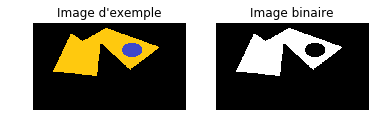

In [2]:
image = plt.imread("image.png")       # on importe une image

def binarise(image):  #docstring : shift+tab sur une fonction pour voir sa bulle d'aide
    """ Binarize a numpy array of shape (M,N,4) and return an array of shape (M,N). """ 
    image = image[:, :,0]
    seuil = np.amax(image)/2
    image = (image >= seuil) * 1
    return image

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(image); plt.axis('off'); plt.title("Image d'exemple")
f.add_subplot(1,2, 2)
plt.imshow(binarise(image),cmap='gray');plt.axis('off'); plt.title("Image binaire")
plt.show(block=True)

<p style='text-align: justify;'>Sachant que nous allons traiter la région blanche, afin que le traitement de l'image soit plus rapide, nous pouvons enlever les lignes et colonnes qui ne contiennent pas de pixels appartenant à $\mathcal{R}$. Nous garderons cependant toujours un contour noir qui sera utile lors du calcul de la distance d'un point à la frontière $\partial\mathcal{R}$. Le fait que l'image soit binaire nous permet d'utiliser les booléens pour un traitement plus rapide.</p>

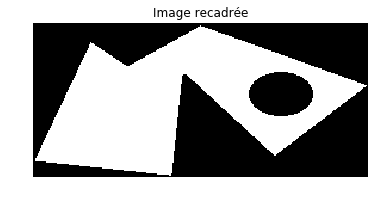

In [3]:
def recadre(imagebinaire):
    """ Trim the array to only keep the region and a one pixel thick frame.
    
    Args ----------
        imagebinaire : boolean numpy array of shape (M,N)
    
    Returns ----------
        imagebinaire : boolean numpy array of shape (-,--) where - is M - (number of all False rows removed)
                                                                 -- is N - (number of all False columns removed).
    """
    
    nbl,nbc=np.shape(imagebinaire)[0],np.shape(imagebinaire)[1]
    masquerow=np.all(np.logical_not(imagebinaire),axis=1)
    masquecol=np.all(np.logical_not(imagebinaire),axis=0)
    for k in reversed(range(1,nbl-1)) :
        if masquerow[k] and masquerow[k+1]: imagebinaire=np.delete(imagebinaire,k,axis=0)
    for k in reversed(range(1,nbc-1)):
        if masquecol[k] and masquecol[k+1]: imagebinaire=np.delete(imagebinaire,k,axis=1)
    return imagebinaire

image=recadre(binarise(image))
plt.imshow(image,cmap='gray')
plt.title("Image recadrée"); plt.axis('off');

## B. Carte des distances <a name="carte"></a>

Pour déterminer les points appartenant au squelette de $\mathcal{R}$, l'une des étapes consiste à calculer la distance de chaque point au point de la frontière le plus proche. Pour cela on définit deux fonctions qui nous seront très utiles par la suite : `coordt` et `coordf` qui renvoient respectivement le tableau des coordonnées des points blancs et noirs où chaque point a pour coordonnées $(x_i,y_i)_{i\in\mathbb{N}}$ et est représenté dans le tableau comme ci-contre.
<p style='text-align: center;'>
$\begin{array}{|r|c|c|} \hline
x_1 & x_2 & \cdots \\ \hline
y_1 & y_2 & \cdots \\ \hline
\end{array}$ </p>

In [4]:
def coordt(imagebinaire):
    """ Search for True elements in an (M,N) numpy array and stack their coordinates. """
    x,y=np.where(imagebinaire==1)
    return np.vstack((x,y))

def coordf(imagebinaire):
    """ Search for False elements in an (M,N) numpy array and vertically stack their coordinates. """
    x,y=np.where(imagebinaire==0)
    return np.vstack((x,y))

La fonction `cartedistance` nous renvoie ensuite une carte où plus le point est éloigné de $\partial\mathcal{R}$ sur l'image originale, plus il sera lumineux sur la carte. Pour faire cela, la fonction calcule pour chaque pixel blanc $X$ de l'image binaire la valeur $\left|\left|X-Y\right|\right|_2$ pour tout $Y\in\partial\mathcal{R}$ et associe au point $X$ sur la carte la plus petite valeur.

In [6]:
def cartedistance(imagebinaire):
    """ Find the distance transform map.
    
    Args ----------
        imagebinaire : boolean numpy array of shape (M,N)
    
    Returns ----------
        imagecarte : float numpy array of shape (M,N)
    """
    
    outregion=coordf(imagebinaire)
    inregion=coordt(imagebinaire)
    imagecarte=np.copy(imagebinaire).astype(float)
    for k in range(np.shape(inregion)[1]):
        imagecarte[tuple(inregion[:,k])]=min(np.linalg.norm(np.array([[inregion[0,k]],[inregion[1,k]]])-outregion,axis=0))
    return imagecarte

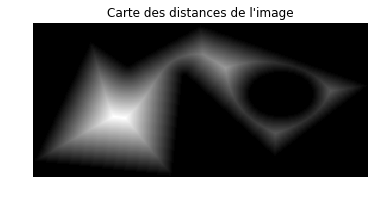

In [7]:
carte=cartedistance(image)
plt.imshow(carte,cmap='gray')
plt.title("Carte des distances de l'image"); plt.axis('off');

A partir de la carte des distances on peut déjà avoir une idée de la forme du squelette. En effet, les pixels qui forment le squelette sont les plus lumineux par rapport à ceux qui les entourent. On peut remarquer la branche du squelette en haut et au centre de l'image très faiblement éclairée : celle-ci risque de disparaître si on ne choisit pas un seuil adapté. Ainsi à partir de la carte des distances on peut, suivant le problème à résoudre, avoir une intuition des éléments importants et appréhender la précision que l'on veut.

## C. Visualisation du gradient <a name="grad"><a/>

<p style='text-align: justify;'>On sait que le gradient de la fonction distance est égal au champ de vecteurs en tout point hors du squelette. Or ce même gradient n'est pas défini en les points de $\Sigma(\mathcal{R})$. Une première approche du squelette peut donc se faire en visualisant le gradient de la fonction distance. Les points en lesquels les flèches venant de différentes directions se rejoignent seront des points de $\Sigma(\mathcal{R})$. </p> 

C'est ce que nous permet de voir la fonction `visualisationgradient`.

In [8]:
def visualisationgradient(carte):
    """ Plot a 2D field of arrows representing the gradient of the distance transform map. """
    cartegrad=np.gradient(carte)
    ax=plt.subplots()[1]
    skip = (slice(None, None, 5), slice(None, None, 5))              #un point sur 5 est traité pour plus de visibilité
    ax.quiver(cartegrad[1][skip], cartegrad[0][skip], carte[skip])
    ax.set(aspect=1, title=r'Visualisation du gradient de $d(X),\ X\in\mathcal{R}\cap\left(\Sigma(\mathcal{R})\right)^c$')
    plt.show()

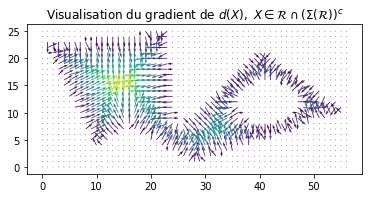

In [9]:
visualisationgradient(carte)

Sur cette carte, plus les vecteurs sont de couleurs jaune/verte, plus la distance du point à la frontière est grande.

## D. Points appartenant possiblement au squelette <a name="firstsquel"></a>

<p style='text-align: justify;'>Pour chaque $X\in\mathcal{R}$, nous allons maintenant calculer $$\overline{I}(X)=\dfrac{2\pi}{8}\sum_{i=1}^8 \langle N_i,\nabla d(X_i)\rangle,$$
où les $X_i$ sont les $8$ voisins de $X$ et $N_i$ le vecteur normal unitaire en $X_i$ au cercle de centre $X$ et de rayon le côté d'un pixel.</p>

Pour ce faire, la fonction `normal` permet d'obtenir les coordonnées du vecteur $N_i$. La fonction `pointsautour`renvoie dans un même tableau les coordonées des $8$ points dans le voisinage de $X$. La fonction `gradenXi`permet d'aller chercher la valeur de $\nabla d(X_i)$ pour les $8\ X_i$. Et enfin la fonction `ibarre` calcule la somme des produits scalaires considérés avec la constante multiplicative.

In [10]:
def bordsnoirs(image):  #au cas où il y aurait un pixel blanc sur le bord de l'image depuis le début
    """ Makes the edges of a 2D array black. """
    nbl,nbc=np.shape(image)[0],np.shape(image)[1]
    image[:,0]=0
    image[0,:]=0
    image[:,nbc-1]=0
    image[nbl-1,:]=0
    return image

def normal(pointorigine,pointatteint):
    """ Computes the coordinates of a vector. """
    coord=np.array([pointatteint[0]-pointorigine[0],pointatteint[1]-pointorigine[1]])
    return coord

def pointsautour(pointorigine):
    """ Array of the coordinates of the 8 pixels around an origin. """
    return pointorigine+np.array([[-1,-1,-1,0,1,1,1,0],[-1,0,1,1,1,0,-1,-1]])

def gradenXi(cartedistance,pointorigine):
    """ Computes the gradient of the distance transform map for all points in the 8-neighborhood.
    
    Args ----------
        cartedistance : float 2D array (distance transform map)
        pointorigine : int array shape(2,1)
        
    Returns ----------
        (2,8) float numpy array
    """
    
    dx,dy=np.gradient(cartedistance)
    listepoints=pointsautour(pointorigine)
    return np.array([dx[tuple(listepoints.tolist())],dy[tuple(listepoints.tolist())]])

def ibarre(cartedistance,pointorigine):
    """ Computes I(X) from a given point X and a distance transform map. """
    N=normal(pointorigine,pointsautour(pointorigine))
    G=gradenXi(cartedistance,pointorigine)
    return (2*np.pi/8)*sum([np.dot(N[:,i],G[:,i]) for i in range(8)])

Le squelette est donc _a priori_ constitué de l'ensemble des points où $|\overline{I}|$ est le plus éloigné de la valeur $0$. On crée donc une nouvelle image aux mêmes dimensions que celle d'origine et pour chaque pixel $X$ qui était blanc, on lui assigne la valeur de $|\overline{I}(X)|$.

In [11]:
def squelhyp(carte,imagebinaire):           
    """ Computes a rough version of the morphological skeleton.
    
    Args ----------
        carte : 2D float array (distance transform map)
        imagebinaire : 2D boolean array (binarized form of the original image)
    
    Returns ----------
        image : 2D float array (hypothetical skeleton)
    """
    
    newcarte=bordsnoirs(carte)
    imagebinaire=bordsnoirs(imagebinaire)
    coord=coordt(imagebinaire)
    image=np.zeros_like(imagebinaire).astype(float)
    for i in range(0,np.shape(coord)[1]):
        image[tuple(coord[:,i].flatten())]=abs(ibarre(newcarte,np.reshape(coord[:,i],(-1,1))))
    return image

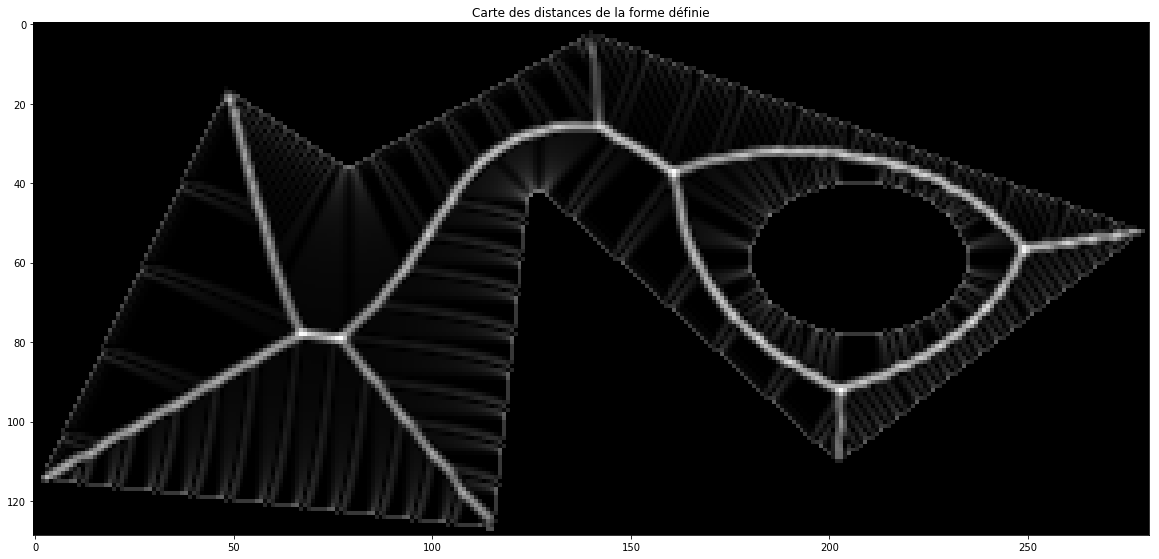

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]  #agrandir les images pour mieux voir le comportement des pixels
squelette=squelhyp(carte,image)
plt.imshow(squelhyp(carte,image),cmap='gray'); plt.title('Carte des distances de la forme définie');

On peut déjà remarquer qu'il existe des variations dans la luminosité des points qui appartiennent _a priori_ à $\Sigma(\mathcal{R})$ et ce à cause la différentiabilité de la frontière (entre autres). Notre but va donc être d'affiner le squelette tout en essayant de garder au moins une connexité naïve.

## E. Squelette final <a name="finalsquel"></a>

Pour obtenir le squelette final, on utilise d'abord un seuil $\varepsilon $ qui permet d'obtenir les points que l'on pourra potentiellement enlever et ensuite on vérifie que le squelette sera toujours connexe si on lui enlève ce point. Dans un premier temps, `arraybin` permet de rendre le squelette hypothétique binaire à partir d'un seuillage par la valeur $\varepsilon$ choisie. Ensuite, on définit deux fonctions : `isblack` qui pour un point donné sur une image en noir et blanc renvoie _True_ si le point est noir et `veriteautour` qui à chaque point dans le voisinage vérifie s'il est blanc ou noir et met ces valeurs de vérité dans une liste.

In [13]:
def arraybin(twodarray,epsilon):
    """ Binarize a 2D array.
    
    Args ----------
        twodarray : 2D float array
        epsilon : threshold for the binarization
    
    Returns ----------
        twodarray : 2D boolean array
    """
    
    twodarray = (twodarray >= epsilon)*1
    return twodarray

def isblack(x,y,binimage):
    """ Return True if a given pixel is black. """
    return binimage[x,y]==0

def veriteautour(point,imagebinaire):
    """ Checks truth value in a 8-neighborhood.
    
    Args ----------
        point : (2,1) int array (center of the 8-neighborhood)
        imagebinaire : 2D boolean array
    
    Returns ----------
        1D boolean array where True in position i means the i-th pixel of the neighborhood is white.
    """
    
    voisins=pointsautour(point)
    return np.array([not isblack(voisins[0,i],voisins[1,i],imagebinaire) for i in range(8)])

Les deux fonctions suivantes permettent de construire un graphe sans cycle sur les points blancs dans le voisinage d'un point $X$ donné. Pour ce faire, `adjacence` construit la matrice d'adjacence au voisinage de $X$. Comme le graphe n'est pas orienté la matrice $(M)_{1\leq i,j\leq 8}$ est symétrique et on a $M_{i,j}=1$ s'il existe une arête entre $i$ et $j$ et $0$ sinon. La fonction `cascycle` permet d'enlever, s'ils existent, les cycles dans le graphe. Comme il n'y a que $8$ sommets on peut lister les cycles possibles et enlever l'arête diagonale si un cycle est présent.

In [14]:
def adjacence(point,imagebinaire): 
    """ Builds the adjacency matrix.
    
    Args ----------
        point : (2,1) int array (center of the neighborhood)
        imagebinaire : 2D boolean array
        
    Returns ----------
        mat : float (8,8) array
    """
    
    mat=np.zeros((8,8))
    for k in range(7):
        if veriteautour(point,imagebinaire)[k]==True and veriteautour(point,imagebinaire)[k+1]==True :
            mat[k][k+1]=mat[k+1,k]=1
    if veriteautour(point,imagebinaire)[7]==True and veriteautour(point,imagebinaire)[7]==veriteautour(point,imagebinaire)[0]:
        mat[0,7]=mat[7,0]=1
    for k in range(0,3):
        if veriteautour(point,imagebinaire)[2*k+1] == True and veriteautour(point,imagebinaire)[2*k+3] == True :
            mat[2*k+1][2*k+3]=mat[2*k+3][2*k+1]=1
    if veriteautour(point,imagebinaire)[7]==True and veriteautour(point,imagebinaire)[7]==veriteautour(point,imagebinaire)[1]:
        mat[7,1]=mat[1,7]=1
    return mat

def cascycle(mat):
    """ Removes the cycles in a (8,8) array (the adjacency matrix). """
    if mat[0,1]==mat[7,0] and mat[7,0]==mat[7,1] : mat[7,1]=mat[1,7]=0
    if mat[1,2]==mat[2,3] and mat[2,3]==mat[1,3] : mat[1,3]=mat[3,1]=0
    if mat[3,4]==mat[4,5] and mat[4,5]==mat[3,5] : mat[3,5]=mat[5,3]=0
    if mat[5,6]==mat[6,7] and mat[6,7]==mat[5,7] : mat[5,7]=mat[7,5]=0
    return mat

On sait qu'un graphe connexe sans cycle est un abre. De plus, un graphe sans cycle est connexe si et seulement si sa caractéristique d'Euler est $1$. On peut donc définir la fonction `isarbre` qui en un point donné, compte le nombre de sommets dans le graphe, utilise le fait que la matrice soit symétrique pour compter les arêtes et renvoie _True_ si le graphe est un arbre.

In [15]:
def isarbre(mat,point,image):
    """ Check if the graph of the 8-neighborhood is a tree.
    
    Args ----------
        mat : (8,8) float array (adjacency matrix)
        point : (2,1) int array (center of the neighborhood)
        image : 2D boolean array
    
    Returns ----------
        True if the graph is indeed a tree, else otherwise.
    """
    
    nbsommet=np.sum(veriteautour(point,image))
    nbarrete=np.sum(cascycle(mat))/2
    return nbsommet-nbarrete==1

Finalement, pour obtenir le squelette de la région $\mathcal{R}$, on vérifie pour chaque point du squelette hypothétique au dessus de $\varepsilon$ la condition :<br>
<div class="alert alert-block alert-danger">
<center> si on retire ce point $\Sigma(\mathcal{R})$ sera-t-il toujours connexe ?</center>
</div>


La fonction `enleveoupas` vérifie si on a cette condition et enlève le point dans le cas échéant. Elle enlève aussi les points qui n'avaient pas de voisins.

Cependant il se peut que parfois il reste des points isolés qui ne sont pas dans $\Sigma(\mathcal{R})$ (cela peut venir d'un bruit sur l'image ou de la présence initiale d'autres composantes connexes). Ces points ne seront plus présents dans les _r_-squelettes qui seront les seuls squelettes utilisés lors de l'application à la chirurgie aux rayons gamma.<br>
Une autre variable qui peut fortement influencer le squelette est $\varepsilon$. En effet, si le seuil est trop petit ou trop élevé on peut avoir des pertes de connexité à certains points ou des branches peuvent appartenir au squelette alors qu'elles ne sont pas censées être dans celui-ci.

In [16]:
def enleveoupas(squelette,epsilon):
    """ Remove points which aren't supposed to be in the morphological skeleton.
    
    Args ----------
        squelette : 2D float array (hypothetical skeleton)
        epsilon : float (threshold for the binarization)
    
    Returns ----------
        squelette : 2D boolean array (morphological skeleton)
    """
    
    squelette=bordsnoirs(arraybin(squelette,epsilon))
    x,y=np.where(squelette > 0)
    coord=np.vstack((x,y))
    for i in range(1,np.shape(coord)[1]): #pour chaque pixel blanc possiblement dans le squelette après la binarisation
        pointi=np.reshape(coord[:,i],(-1,1))
        voisins=pointsautour(pointi)
        if sum(squelette[tuple(voisins.tolist())]) == 8: continue    #ne pas créer de trous
        elif sum(squelette[tuple(voisins.tolist())]) >1 :
            if isarbre(cascycle(adjacence(pointi,squelette)),pointi,squelette) :#si le graphe autour est un arbre on enlève
                squelette[tuple(pointi.flatten())] = 0
            else :
                squelette[tuple(pointi.flatten())] = 1                      #sinon le point est dans le squelette
        if sum(squelette[tuple(voisins.tolist())]) == 0:
            squelette[tuple(pointi.flatten())] = 0         #les points seuls sont enlevés (bruit)
    return squelette

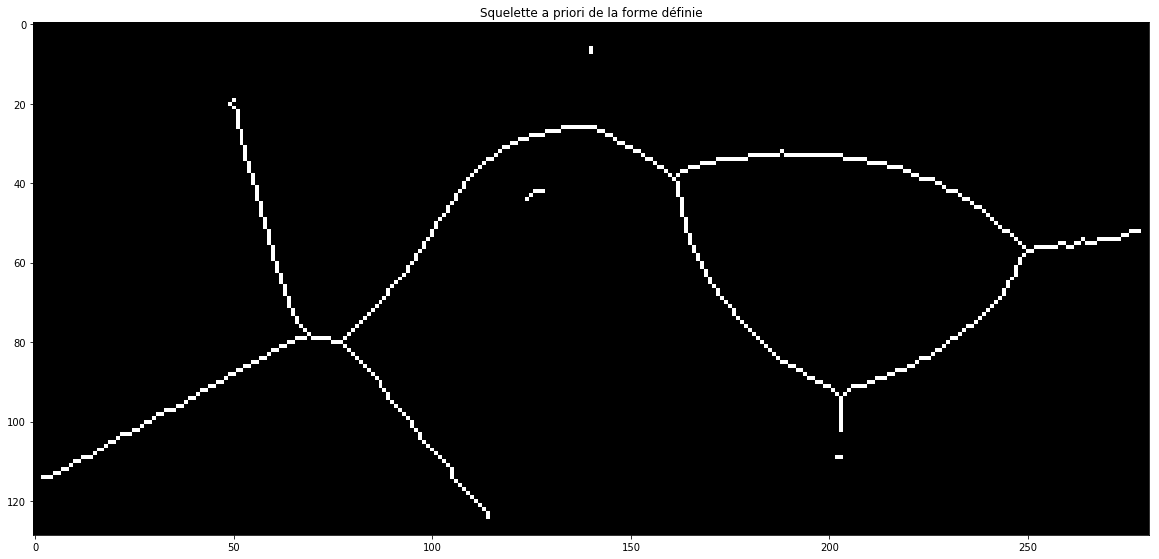

In [17]:
squelette=enleveoupas(squelette,np.amax(squelette)/2.5)   #valeur de seuil étant le maximum atteint divisé par 2.5
plt.imshow(squelette,cmap='gray'); plt.title('Squelette a priori de la forme définie');

Dans notre cas on remarque que le seuil choisi nous a fait perdre une branche (celle en haut au centre de l'image).

## F. Exemple du rectangle <a name='rec'></a>

Après avoir considéré un polygone avec un trou, regardons le squelette d'un objet qui nous est plus familier : le rectangle.

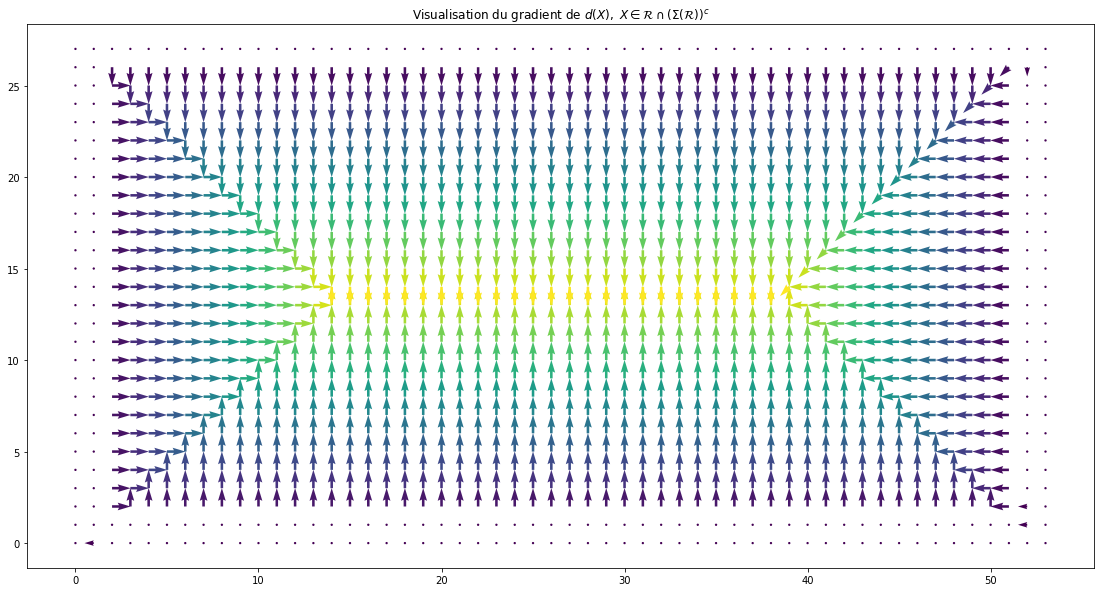

0 : imagebinaire, 1 : cartedistance, 2 : le gradient numpy dx,dy, 3 : possible skeleton, 4 : squelette final


In [18]:
def getallrec(image):
    """ Get all the elements for the construction of the morphological skeleton.
    
    Args ----------
        image : float (M,N,4) numpy 
    Returns ----------
        list :
            binaire : 2D boolean array (binarized image)
            cartedistance : 2D float array (distance transform map)
            gradient : set of 2 arrays with the same shape corresponding to the derivatives
            skelhyp : 2D float array (hypothetical skeleton)
            squelette : 2D boolean array (morphological skeleton)
    """
    
    binaire=recadre(binarise(image))
    carte=cartedistance(binaire)
    cartegrad=visualisationgradient(carte)
    gradient=np.gradient(carte)
    skelhyp=squelhyp(carte,binaire)
    squelette=enleveoupas(skelhyp,np.amax(skelhyp)/2)
    print("0 : imagebinaire, 1 : cartedistance, 2 : le gradient numpy dx,dy, 3 : possible skeleton, 4 : squelette final")
    return [binaire,carte,gradient,skelhyp,squelette]

rectangle=plt.imread('rectangle.png')
objets=getallrec(rectangle)

Le gradient nous permet de confirmer notre intuition et coïncide bien avec la théorie effectuée. 

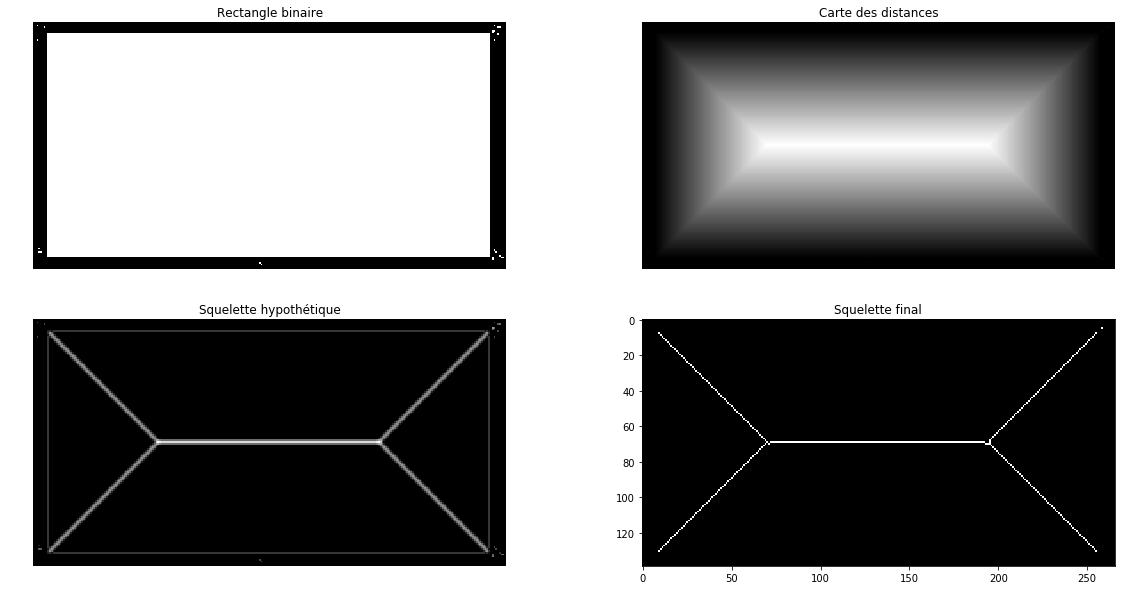

In [19]:
f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(objets[0],cmap='gray'); plt.axis('off'); plt.title("Rectangle binaire")
f.add_subplot(2,2, 2)
plt.imshow(objets[1],cmap='gray');plt.axis('off'); plt.title("Carte des distances")
f.add_subplot(2,2,3)
plt.imshow(objets[3],cmap='gray');plt.axis('off'); plt.title("Squelette hypothétique")
f.add_subplot(2,2,4)
plt.imshow(objets[4],cmap='gray'); plt.title("Squelette final");
plt.show(block=True)

Cette visualisation représente les étapes effectuées pour la construction du squelette. On remarquera notamment le fait que la frontière apparait dans le squelette hypothétique mais n'est plus dans le squelette final. Ci-dessous nous pouvons voir que le squelette est naïvement connexe.

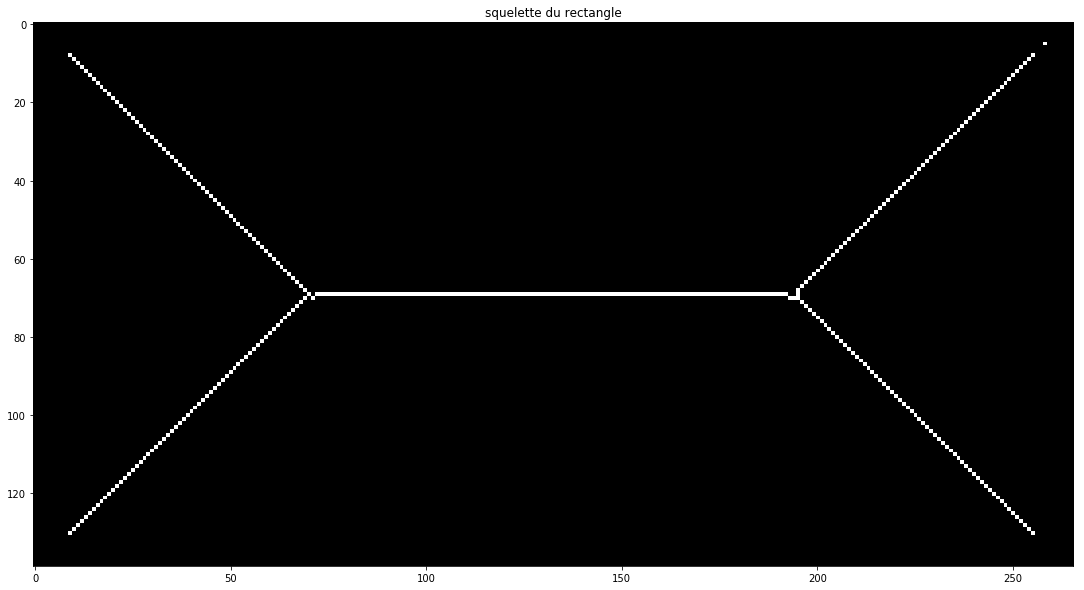

In [20]:
plt.imshow(objets[4],cmap='gray'); plt.title('squelette du rectangle');

Ainsi nous reconnaissons bien le squelette d'un rectangle. On peut remarquer une asymétrie au niveau des fourches, celle-ci est due à la parité des dimensions du rectangle. On aurait pu forcer le squelette à garder les deux lignes de la bande centrale mais l'épaisseur du squelette n'aurait alors pas été minimale.

Voici quelques données sur des tests avec des rectangles de différentes tailles. On y voit ainsi l'une des grandes utilités du squelette en informatique : celui-ci nous permet de n'avoir à gérer qu'une partie très restreinte des données sans pour autant perdre leurs propriétés.

|dimensions du rectangle | nombre de pixels dans le rectangle | pixels du squelette hypothétique non nuls | pixels dans le squelette final | pourcentage de pixels gardés | temps d'obtention du squelette final depuis la carte (incluse) avec process_time() |
| :-: | - | :-: | -: | :-| :- |
| (50,50) | 2 500 | 476 | 96 | **3.84** | 0.8906 |
| (61,150) | 9 150 | 854 | 207 | **2.26** | 4.2344 |
| (80,130) | 10 400 | 976 | 210 | **2.02** | 5.2656 |
| (120,200) | 24 000 | 1 496 | 320 | **1.33** | 18.2813 |
| (100,350) | 35 000 | 1 976 | 450 | **1.29** | 35.0625 |
| (129,418) | 53 922 | 2 134 | 543 | **1.01** | 73.7656 |
| (220,335) | 73 700 | 2 636 | 555 | **0.7531** | 130.4219 |

Ci-dessous nous cherchons à approcher nos données expérimentales par des fonctions pour pouvoir avoir une idée du temps de traitement pour obtenir le squelette. Le deuxième graphique représente le pourcentage de pixels gardés. Pour faire ces deux représentations nous utilisons la fonction `curve_fit` de scipy. 

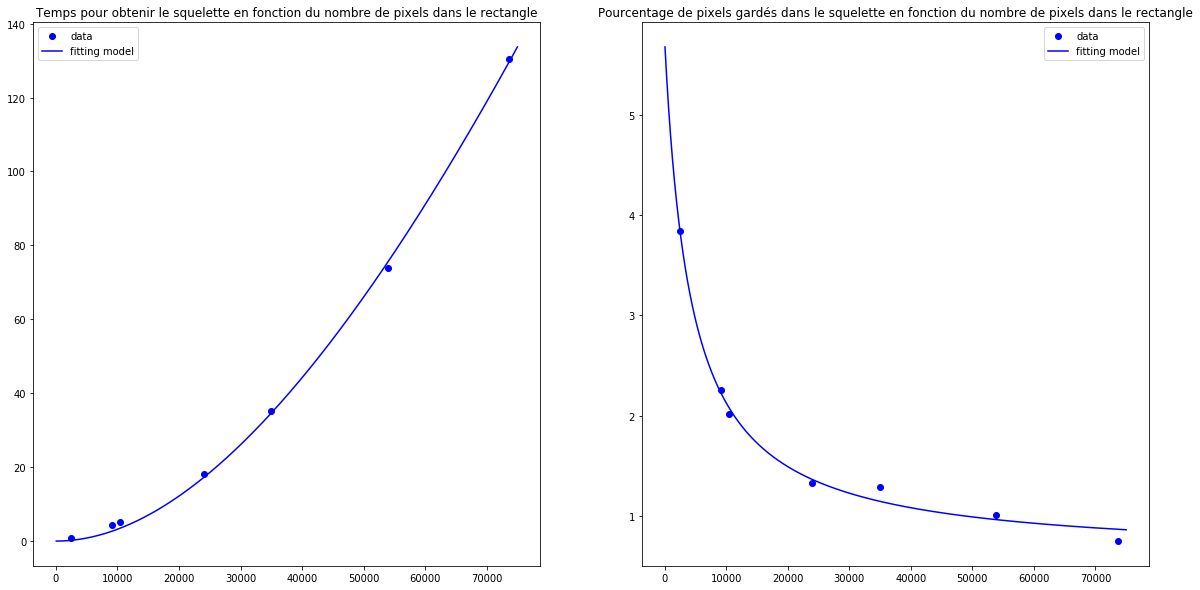

Les coefficients pour la fonction du temps sont : [3.39140672e-08 5.69099638e-06] .
Les coefficients pour la fonction du pourcentage sont : [ -185.1915686    505.00237548 -4216.64146587  4335.08063745] .


In [21]:
from scipy.optimize import curve_fit
x=np.array([2500,9150,10400,24000,35000,53922,73700])
ytemps=np.array([0.8906,4.2344,5.2656,18.2813,35.0625,73.7656,130.4219])
ypourcentage=np.array([3.84,2.26,2.02,1.33,1.29,1.01,0.7531])

def approch(t,a,b): return a*t/(b+1/t)
def approchpour(t,a,b,c,d) : return a+b*np.exp((c-t)/(d+t))


popfittemps,poperr = curve_fit(approch,x,ytemps,maxfev=100000)
popfitpour,poperrpour = curve_fit(approchpour,x,ypourcentage,maxfev=100000)

toplot=np.arange(50,75000)

fig=plt.figure()
fig.add_subplot(1,2,1)
plt.plot(x, ytemps, 'bo', label='data');
plt.plot(toplot,approch(toplot,*popfittemps), "b", label = "fitting model")
plt.legend()
plt.title('Temps pour obtenir le squelette en fonction du nombre de pixels dans le rectangle');
fig.add_subplot(1,2,2)
plt.plot(x, ypourcentage, 'bo', label='data');
plt.plot(toplot,approchpour(toplot,*popfitpour), "b", label = "fitting model")
plt.legend()
plt.title('Pourcentage de pixels gardés dans le squelette en fonction du nombre de pixels dans le rectangle');
plt.show(block=True);
print('Les coefficients pour la fonction du temps sont :',popfittemps,'.')
print("Les coefficients pour la fonction du pourcentage sont :",popfitpour,'.')

On observe que plus le nombre de pixels est grand, plus le temps de traitement est conséquent. Cependant le pourcentage de pixels gardés décroît très rapidement, donc nos deux courbes suivent des tendances opposées. En pratique cela signifie qu'il faut faire un choix entre la qualité de l'image originale (et donc la qualité du squelette) et le temps de traitement.

# <center>III. Chirurgie aux rayons gamma <a name='chir'></a></center>
## A. Envoyer des rayons gamma <a name='tir'></a>

Afin de traiter la tumeur, nous devons être en mesure de pouvoir envoyer des disques formés par les rayons gamma. Sachant que le _Gamma Knife_, qui est la machine de radiochirurgie communément utilisée, permet d'envoyer des disques de tailles variées (pouvant être différentes de celles proposées dans le chapitre de _Mathématiques et technologies_ : $2$, $4$, $7$ et $9$_mm_), nous avons créé des fonctions adaptables à n'importe quelle taille de rayons.

La première fonction `getmask` permet à partir d'un point et d'un rayon de définir les pixels de l'image qui seront contenus dans le disque. Ce masque booléen permet de gagner du temps dans le traitement de l'image et évite l'utilisation d'une boucle _for_.

La fonction `checkclash` permet de vérifier que deux traitements ne se recontreront pas, notre but n'est pas de recouvrir toute la tumeur mais seulement assez pour que ce soit suffisant d'un point de vue médical. Pour ce faire on travaille sur l'image qui sera renvoyée à la toute fin de la chirurgie (cette image ne sera pas binaire d'où la condition de comparaison par inégalité dans le _if_). De plus, la fonction _any()_ est _lazy_ ce qui permet au programme de ne pas avoir à vérifier tous les pixels s'il en existe un avant le dernier qui vérifie la condition. En pratique les algorithmes utilisés en chirurgie permettent des chevauchements des zones traitées.

Enfin, la fonction `shootcercle` envoie un disque de rayons gamma sur l'image qui sera retournée à la fin. De plus, en préparation de la suite, elle modifie aussi le squelette en elevant les points touchés de celui-ci et elle fait de même sur la carte des distances. Ceci permettra de ne plus considérer les parties déjà touchées par les rayons gamma lors du passage du _Gamma knife_ aux itérations suivantes.

In [22]:
def getmask(point,rayon,image):
    """Creates a mask in the shape of a disk.
    
    Args ----------
        point : (2,1) int array (center of the disk)
        rayon : float
        image : 2D float array
    
    Returns ----------
        mask : 2D boolean aray (True where the pixels are in the disk of center point and radius rayon)
    """
    
    coord1,coord2=tuple(point.flatten())[0],tuple(point.flatten())[1]    
    taillel,taillec=np.shape(image)[0],np.shape(image)[1]
    y,x=np.ogrid[-coord1:taillel-coord1, -coord2:taillec-coord2]
    mask= x*x+y*y <= rayon*rayon
    return mask

def checkclash(masque,image): #utilisée pour voir si deux disques vont se superposer ou non (l'image ne sera pas binaire)
    """ Checks if a pixel in the mask has a value above 1. """
    return any(image[masque]>1)
    
def shootcercle(masque,image,squelette,carte,rayon):
    """Project a disk.
    
    Args ----------
        masque : 2D boolean array
        image : 2D float array
        squelette : 2D boolean array (morphological skeleton)
        carte : 2D float array (distance transform map)
        rayon : float (radius of the disk)
    
    Returns ----------
        image : 2D float array (elements in the disk were changed to the value of the radius)
        squelette : 2D boolean array (elements in the disk were changed to 0)
        carte : 2D float array (elements in the disk were changed to 0)
    """
    
    image[masque]=rayon
    squelette[masque]=0,
    carte[masque]=0
    return image,squelette,carte

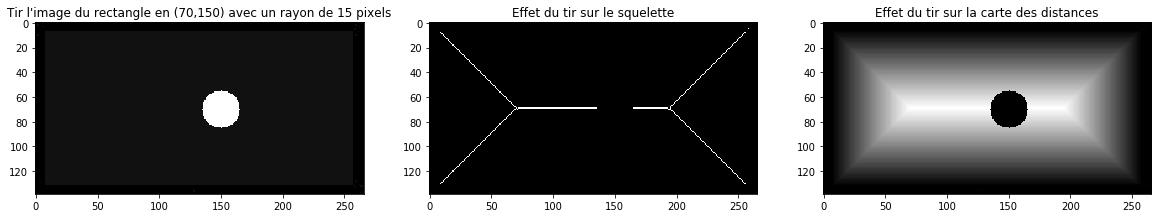

In [23]:
imagetest,squelettetest,cartetest=np.copy(objets[0]),np.copy(objets[4]),np.copy(objets[1])
renvoi=shootcercle(getmask(np.array([[70],[150]]),15,imagetest),imagetest,squelettetest,cartetest,15)
plt.subplot(1,3,1)
plt.imshow(renvoi[0],cmap='gray'); plt.title("Tir l'image du rectangle en (70,150) avec un rayon de 15 pixels");
plt.subplot(1,3,2),
plt.imshow(renvoi[1],cmap='gray'); plt.title("Effet du tir sur le squelette")
plt.subplot(1,3,3)
plt.imshow(renvoi[2],cmap='gray'); plt.title("Effet du tir sur la carte des distances");

## B. Extrémités et fourches dans le $r$-squelette <a name='where'></a>

Pour couvrir le plus de surface possible, on décide de points stratégiques où placer le centre des disques. On les définit comme étant ceux où il y a au moins deux points de tangence entre la sphère et $\partial\mathcal{R}$. Ceux-ci sont les points du squelette, notre but est d'envoyer les disques en suivant deux règles <a name='rules'></a> :

<div class="alert alert-block alert-info">
1- S'il existe des fourches dans le squelette (pixel où le segment se sépare pour aller dans plus d'une direction) alors on commence par envoyer les disques de plus grand rayon possible sur ces points,
</div>
<div class="alert alert-block alert-info">
2-  Après avoir possiblement envoyé des disques centrés en les fourches, on envoie des disques centrés en les points des extrémités du squelette.
</div>


Cependant, le disque devant être contenu dans $\mathcal{R}$, il faut que la distance du centre du disque à la frontière soit supérieure ou égale à celle du rayon du disque envoyé. C'est pour cela que nous utilisons la notion de _r_-squelette. Si on a un disque de rayon $15$ pixels alors les disques centrés en les points du $15$-squelette seront bien tous dans $\mathcal{R}$.

La fonction `rsquel` permet de construire le _r_-squelette à partir d'un squelette, de la carte des distances associée et d'un rayon. Ensuite, la fonction `findextremitesfourches` parcourt tous les points du squelette et détermine suivant le nombre de voisins qu'a le point s'il est un point d'une extrémité, une fourche (auxquels cas ils sont stockés dans deux différents tableaux) ou alors simplement un point à l'intérieur d'un segment (auquel cas on ne s'occupe pas du point).

In [24]:
def rsquel(rayon,carte,squel):
    """ Get the r-skeleton.
    
    Args ----------
        rayon : float, minimal distance between the boundary and the skeleton
        carte : 2D float array, distance transform map
        squel : 2D boolean array, morphological skeleton
    
    Returns ----------
        rsquel : 2D boolean array, r-skeleton
    """
    
    rsquel=np.copy(squel)
    x,y=np.where(rsquel>0)
    coord=np.vstack((x,y))
    for i in range(np.shape(coord)[1]):
        if carte[tuple(coord[:,i])]< rayon : rsquel[tuple(coord[:,i])]=0 #on enlève les points 'r-proches' de la frontière
    return rsquel

In [25]:
def findextremitesfourches(squelette,carte):
    """ Find extremities and separation points.
    
    Args ----------
        squelette : 2D boolean array, morphological skeleton
        carte : 2D float array, distance transform map
    
    Returns ----------
        tabcoord : (2,-) int array, coordinates of the extremities
        tabtrid : (2,-) int array, coordinitates of the separation points
    """

    coord=coordt(squelette)
    tabcoord=np.array([[],[]])
    tabtrid=np.array([[],[]])
    for i in range(np.shape(coord)[1]):
        point=np.reshape(coord[:,i],(-1,1))
        if sum(veriteautour(point,squelette))==1 :   # une extrémité n'a qu'un voisin
            tabcoord=np.concatenate((tabcoord,point),axis=1)
        if sum(veriteautour(point,squelette))>=3:    # un point de séparation a au moins 3 voisins
            tabtrid=np.concatenate((tabtrid,point),axis=1)
    return tabcoord,tabtrid

Prenons un rayon de $60$ pixels et construisons le $60$-squelette du rectangle. Pour encore accentuer la différence avec le squelette du rectangle d'origine, on peut rajouter les pixels des quatre extrémités du $0$-squelette.

coordonnées des extrémités du rectangle d'origine :
 [[  8.   8. 130. 130.]
 [  9. 255.   9. 255.]] 

 Visualisation du r-squelette :


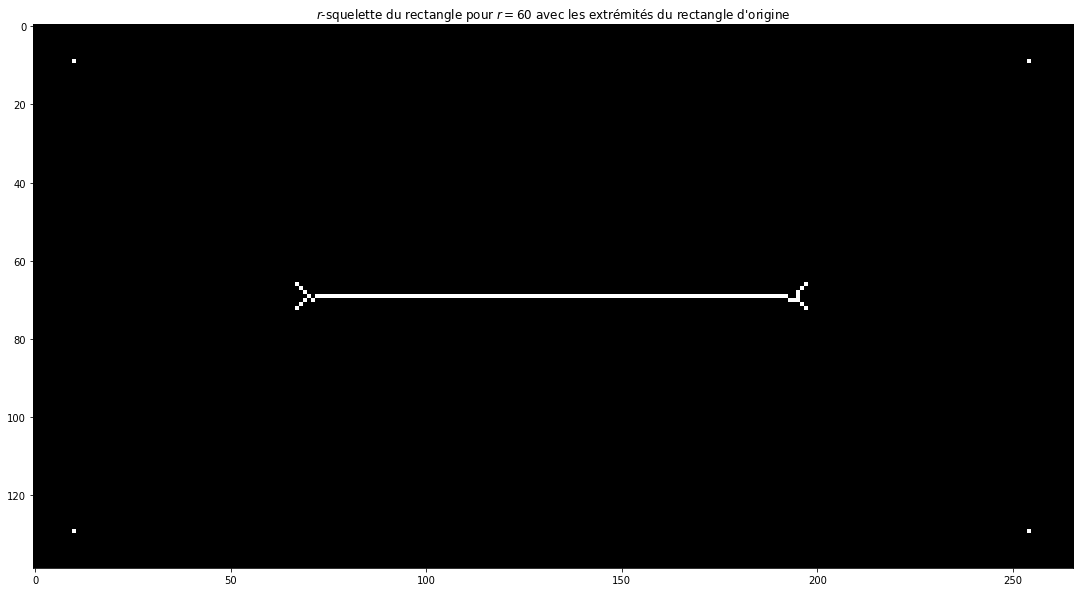

In [26]:
print("coordonnées des extrémités du rectangle d'origine :\n",findextremitesfourches(objets[4],objets[1])[0],
      "\n\n Visualisation du r-squelette :")
rsquelette=rsquel(60,objets[1],objets[4])
rsquelette[9,10]=rsquelette[9,254]=rsquelette[129,10]=rsquelette[129,254]=1
plt.imshow(rsquelette,cmap='gray');
plt.title(r"$r$-squelette du rectangle pour $r=60$ avec les extrémités du rectangle d'origine");

Le $r$-squelette nous permet donc un gain de temps car nous avons moins de pixels à traiter. De plus, celui-ci nous permet de ne pas ajouter de condition supplémentaire sur la distance à la frontière dans l'algorithme.

## C. Algorithme de la chirurgie <a name='killtumeur'></a>

Le _Gamma Knife_ ayant différentes tailles de rayons pour les disques de rayons gamma (même si on retrouve souvent les valeurs $2,4,7,9$ _mm_), il peut être utile de définir la taille des rayons que l'on souhaite. Pour cela, nous avons créé la fonction `listerayons` qui vous demande de rentrer une à une les quatre valeurs des rayons disponibles. Si les valeurs rentrées ne sont pas des réels positifs, elle en prend la valeur absolue. De plus, si le rayon n'est pas un nombre réel, pour ne pas impacter l'expérience dans la suite on donne une valeur qui n'influencera pas le rendu final.

Ces rayons étant rentrés en millimètres et les images étant en pixels, on prend $1$_mm_ comme étant $3.77952755905511$ pixels et la fonction `convmmpix` permet d'effectuer la conversion.

In [27]:
def listerayons():
    """ Input the 4 radius in millimeters one by one.
    
    Returns ----------
        liste : (4,) positive float array
    
    Exception ----------
        If the input value can't be turned to float, the value is turned to 10**999.
    """
    
    print('Rentrez les 4 rayons en millimètres un-par-un.')
    liste = [0,0,0,0]
    for i in range(4):
        try :
            liste[i]=abs(float(input()))
        except ValueError:
            liste[i]=10**999
    return np.array(liste)

def convmmpix(rayon):
    """ 'Convert' the radius into pixels (this conversion depends on the density per inches of
        pixels and we assume that a pixel is a square which is not the case in reality). This assumption comes from
        the fact that the image is an array and one pixel can be compared to one item in the array here. """
    return rayon*3.77952755905511


Ensuite, pour faire fonctionner l'algorithme de la chirurgie, il nous faut définir trois fonctions :
*  `getref` qui prend en entrée la liste des rayons utilisés et l'image sur laquel on tire les disques. Sachant que les disques envoyés sur l'image finale ne sont pas en noir et blanc, cette _image de référence_ n'est que la version binaire de l'image finale.
*  `getsquelette` permet à partir d'une carte des distances et d'une image binaire de construire le squelette hypothétique puis de renvoyer le squelette final. Elle ne fait que combiner les fonctions `squelhyp` et `enleveoupas` définies précédemment.
*  `updatemaps` est la fonction qui va permettre de faire plusieurs itérations dans le programme de la chirurgie. Après avoir envoyé les premiers disques de rayons gamma, il nous faudra reconstruire une nouvelle carte des distances et un nouveau squelette pour le reste de la région qui n'a pas été touché par les rayons. Cette fonction utilise donc `getref` pour avoir une image de référence en noir et blanc puis construit la nouvelle carte des distances. Ensuite, à l'aide de `getsquelette` elle peut nous renvoyer la carte des distances et le squelette de la nouvelle région qui nous intéresse.

In [28]:
def getref(imagefinale,listerayons):
    """ Binarize an array which has been touched by a disk. 
    
    Args ----------
        imagefinale : 2D float array (array representing where all the rays are sent)
        listerayons : (4,) float array
        
    Returns ----------
        imageref : 2D boolean array, binarized version of imagefinale where every pixel touched by a disk is False
    """
    
    imageref=np.copy(imagefinale)
    futuresnoires=np.where(np.logical_or(imageref ==0, imageref>=min(listerayons)))
    futuresblanches=np.where(np.logical_and(imageref !=0, imageref <= min(listerayons)))
    for i in enumerate(np.transpose(futuresnoires)):
        imageref[tuple(i[1])]=0
    for i in enumerate(np.transpose(futuresblanches)):
        imageref[tuple(i[1])]=1
    return imageref

def getsquelette(carte,imageref):
    """ Use squelhyp and enleveoupas to get directly the morphological skeleton. """
    skelhyp=squelhyp(carte,imageref)
    squelette=enleveoupas(skelhyp,np.amax(skelhyp)/2)
    return squelette

def updatemaps(squel,carte,imagefinale,listerayons):
    """ Get the updated version of the modified array.
    
    Args ----------
        squel : 2D boolean array, morphological skeleton
        carte : 2D float array, distance transform map
        imagefinale : 2D float array, array where the disks will appear with one colour per radius
        listerayons : (4,) float array, array of the 4 radius available for the disks
    
    Returns ----------
            carte : 2D float array, new distance transform map
            squelette : 2D boolean array, new morphological skeleton
    """
    
    imageref=getref(imagefinale,listerayons)
    carte=cartedistance(imageref)
    squelette=getsquelette(carte,imageref)
    return carte,squelette

L'algorithme de la chirurgie permet de mettre en pratique tous les éléments définis précédemment. On lui donne en entrée l'image binaire sur laquelle on veut envoyer les disques de rayons gamma, le squelette de cette image, la liste des rayons disponibles en millimètres, la carte des distances mais aussi un nombre d'itérations maximales par sécurité.

Pour chaque rayon dans la liste, on construit le _r_-squelette associé. On lui trouve ses extrémités et ses points de fourches et, comme expliqué dans [les conditions](#rules), on s'occupe en priorité des points formant une fourche. La fonction `checkclash` permet de savoir si, en envoyant un disque, on ne va pas créer des points où deux disques vont s'intersecter. Si la condition est vérifiée alors le disque est envoyé. Une fois que tous les points de fourche ont été traités, on passe aux points des extrémités. La même condition doit être vérifiée pour envoyer le disque. Pour chaque tir effectué, une nouvelle version de l'image finale est affichée avec le nouveau tir. Une image de référence temporaire est ensuite créée. Si on a déjà fait une itération et si cette image de référence est la même que celle de l'étape précédente alors cela veut dire que l'on n'a pas pu envoyer de nouveaux disques de rayons gamma donc on peut arrêter l'algorithme. Sinon, on refait la procédure avec le nouveau squelette trouvé grâce à la fonction `updatemaps`. Tant que l'on est en dessous du nombre d'itérations maximales et que les deux images de référence sont différentes on peut donc continuer. Une fois la procédure finie on obtient l'image finale des disques envoyés.

In [29]:
def chirurgie(imagebinaire,squelette,listerayons,carte,nmax):
    """ Shoot disks of determined radius and centered in splitting points or extremities while it can.
    
    Args ----------
        imagebinaire : 2D boolean array, binarized image to do the surgery on
        squelette : 2D boolean array, morphological skeleton
        listerayons : (4,) float array, list of available radius for the disks
        carte : 2D float array, distance transform map
        nmax : int, number of maximal iterations to keep some control over the time spent
    
    Returns ----------
        imagefinale : 2D float array, map of where the disks of each radius reached their target 
    """
    
    imagefinale=np.copy(imagebinaire)
    listerayons=-np.sort(-convmmpix(listerayons)) #ordre décroissant
    n=0
    while(n<=nmax):
        for i in enumerate(listerayons):
            rsquelette=rsquel(listerayons[i[0]],carte,squelette)
            extrem,fourches=findextremitesfourches(rsquelette,carte)
            if fourches.size !=0 :
                for k in enumerate(np.transpose(fourches)): #traite les fourches
                    if not checkclash(getmask(np.reshape(k[1],(-1,1)),i[1],imagefinale),imagefinale):
                        imagefinale,squelette,carte=shootcercle(getmask(np.reshape(k[1],(-1,1)),i[1],imagefinale),
                                                                imagefinale,squelette,carte,i[1])
                        plt.imshow(imagefinale,cmap='Reds')
                        plt.show()
            for k in enumerate(np.transpose(extrem)):   #traite les extrémités
                if not checkclash(getmask(np.reshape(k[1],(-1,1)),listerayons[i[0]],imagefinale),imagefinale):
                    imagefinale,squelette,carte=shootcercle(getmask(np.reshape(k[1],(-1,1)),listerayons[i[0]],imagefinale),
                                                            imagefinale,squelette,carte,listerayons[i[0]])
                    plt.imshow(imagefinale,cmap='Reds')
                    plt.show()
        imagereftemp=getref(imagefinale,listerayons)
        if n>=1 and np.array_equal(imagereftemp,imageref) : break;  #sortie du while si aucun changement ne s'est opéré
        else :
            imageref=imagereftemp
            carte,squelette=updatemaps(squelette,carte,imageref,listerayons)
            n+=1
    return imagefinale

In [30]:
liste=listerayons()   #prendre 2,4,7 et 9 pour le rectangle permet de bien voir les différentes 
                 # tailles des rayons et les étapes en un temps raisonnable (3'30 environs avec l'affichage de chaque tir)
liste

Rentrez les 4 rayons en millimètres un-par-un.
2
4
7
9


array([2., 4., 7., 9.])

In [31]:
from time import process_time  #pour pouvoir quantifier la durée du traitement suivant la taille d'une image

<div class="alert alert-block alert-warning">
En reprenant les objets créés précédemment pour l'image du rectangle on peut appliquer l'algorithme de la chirurgie.
</div>

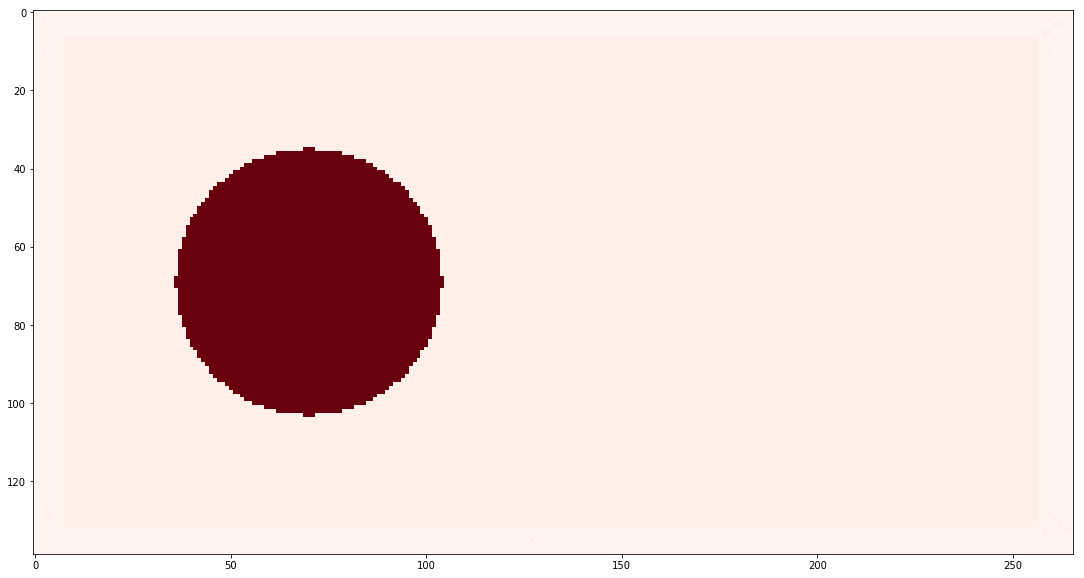

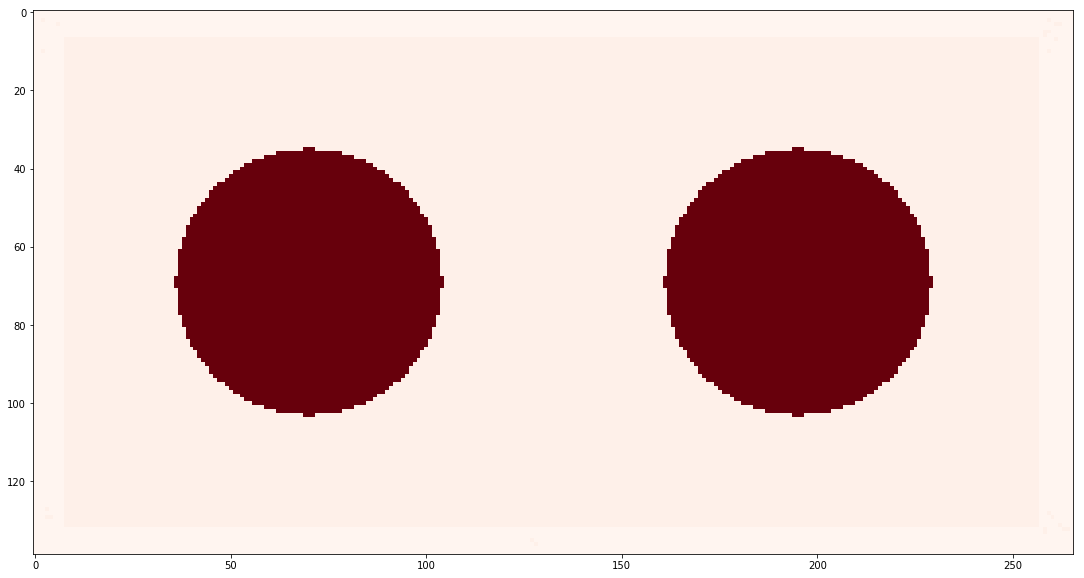

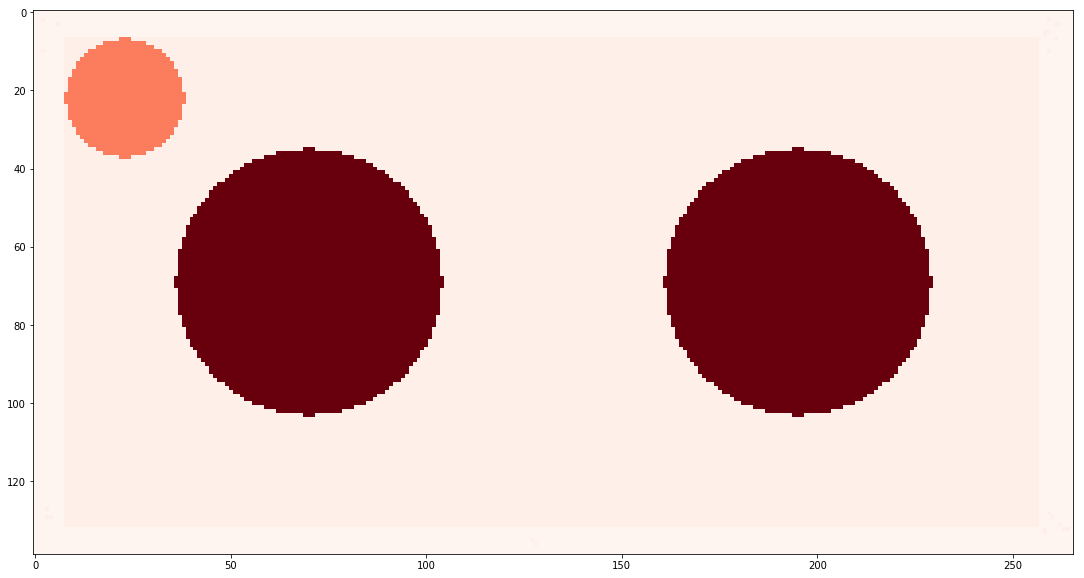

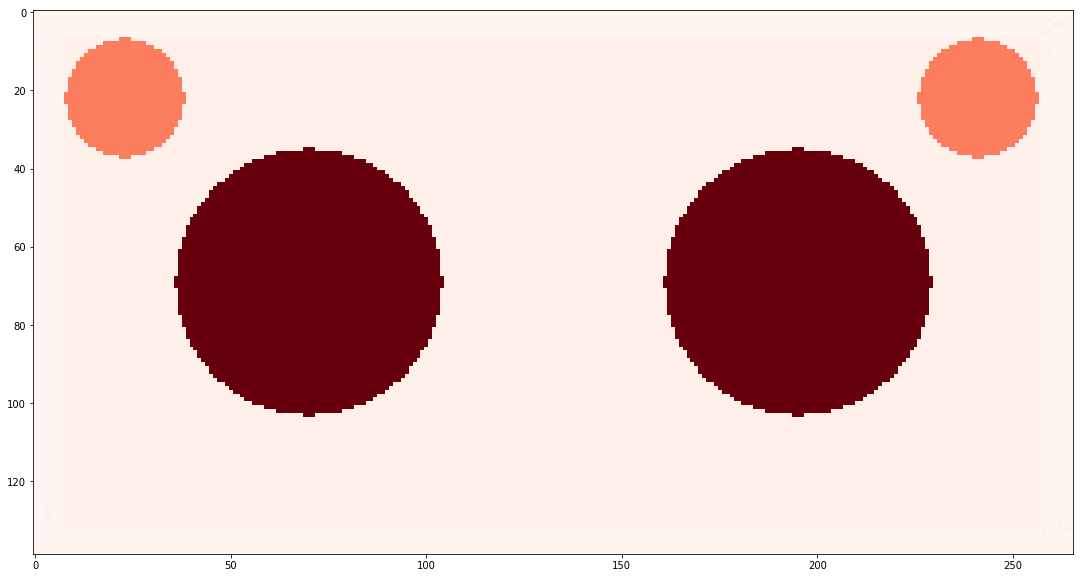

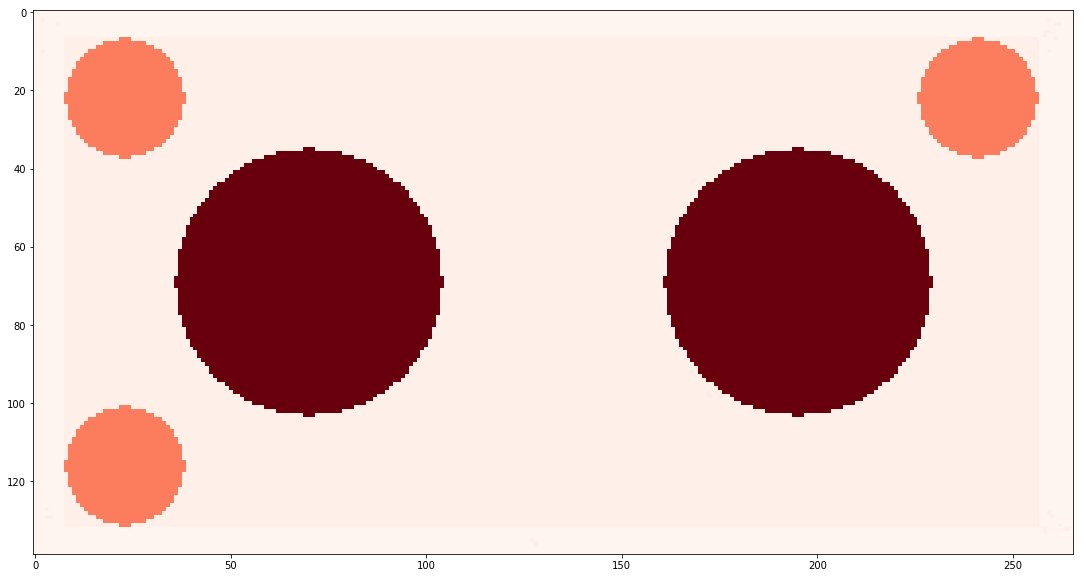

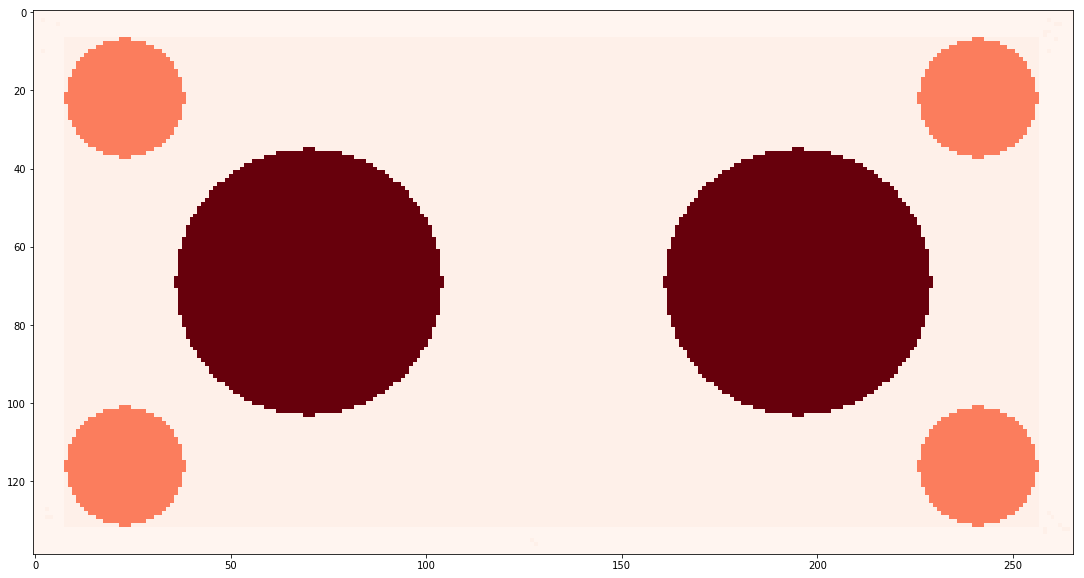

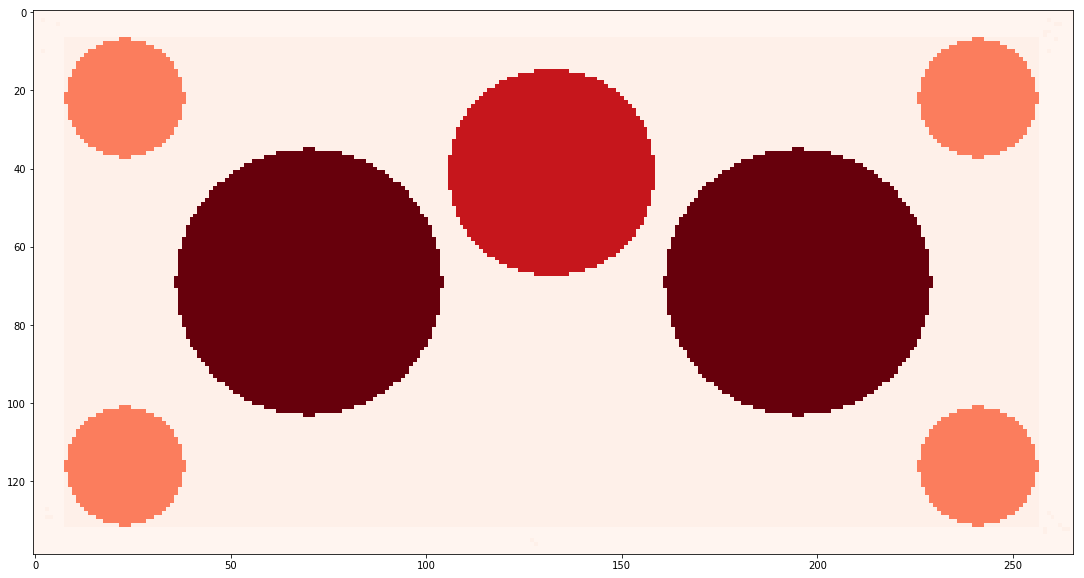

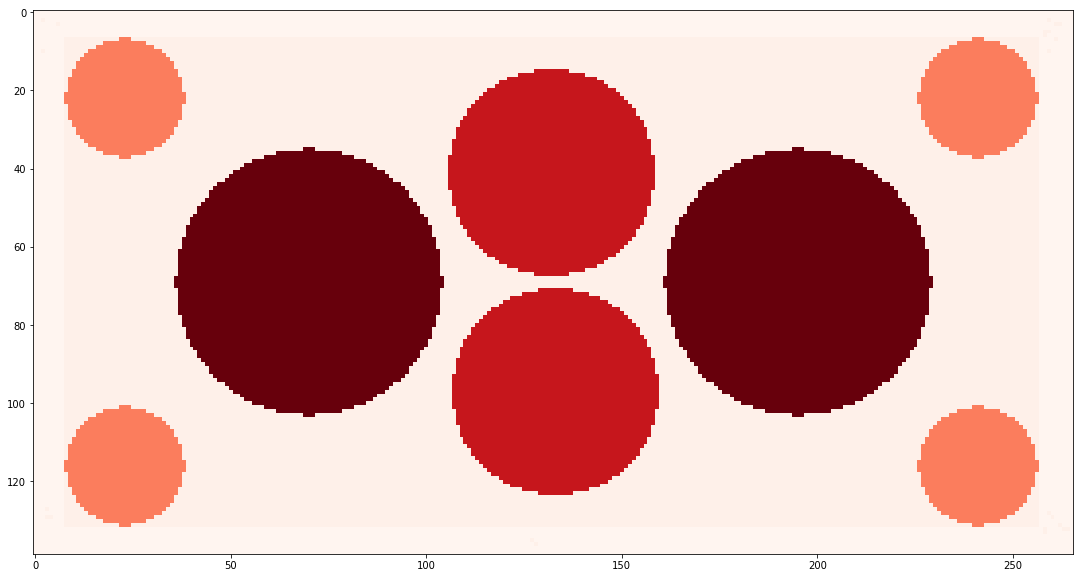

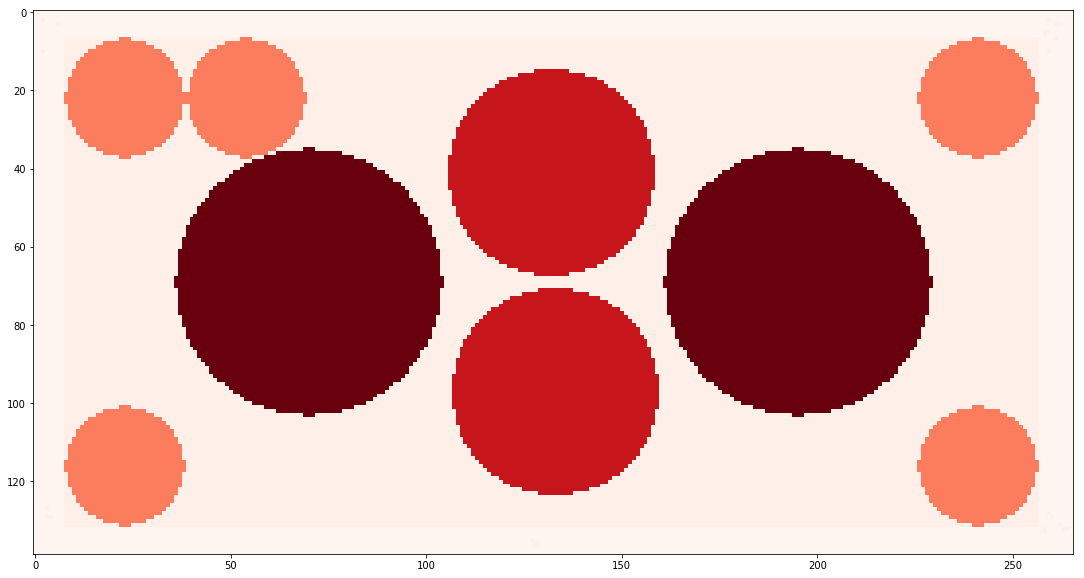

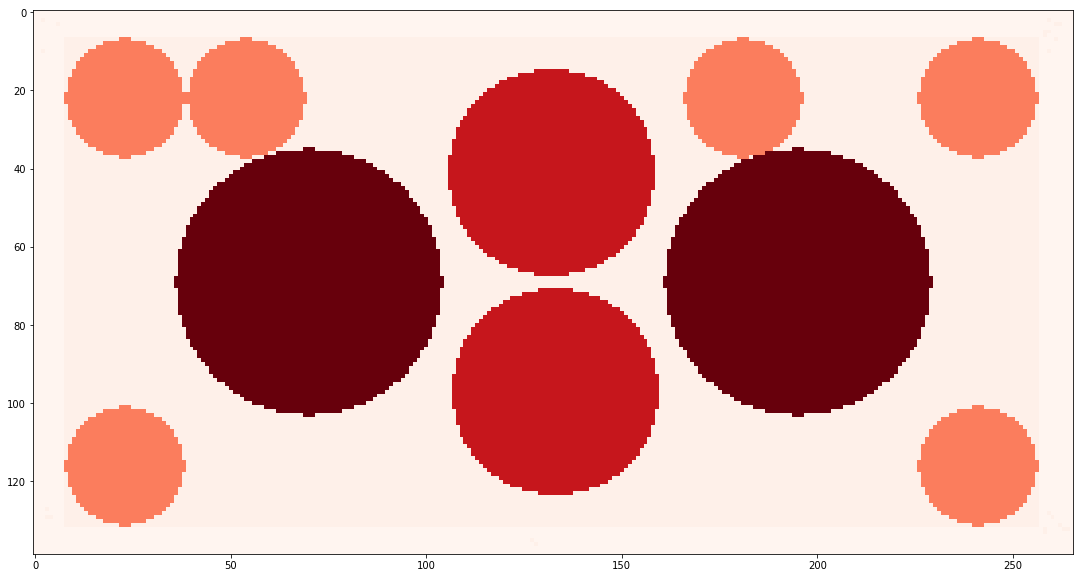

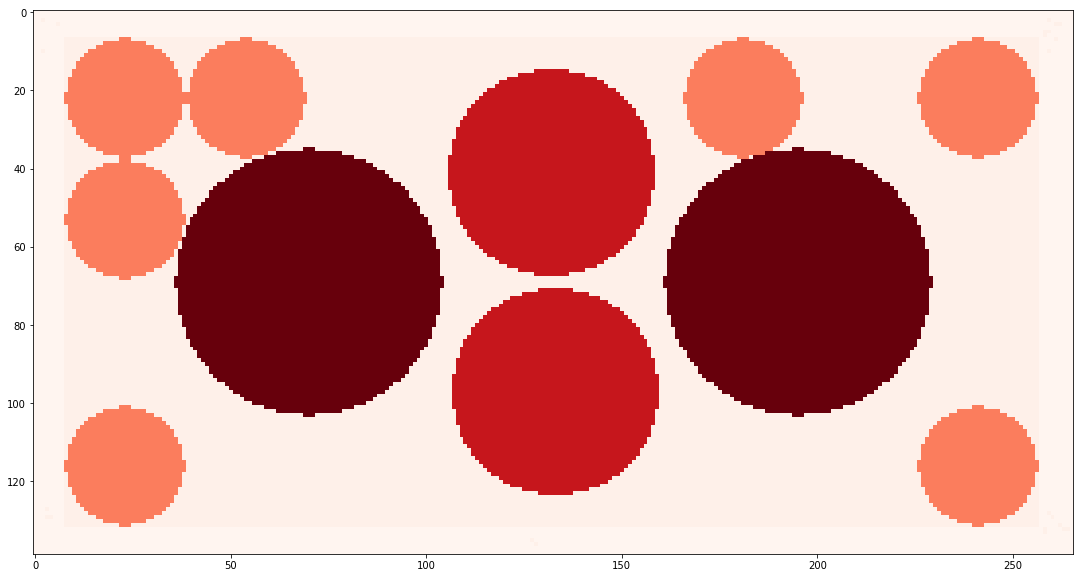

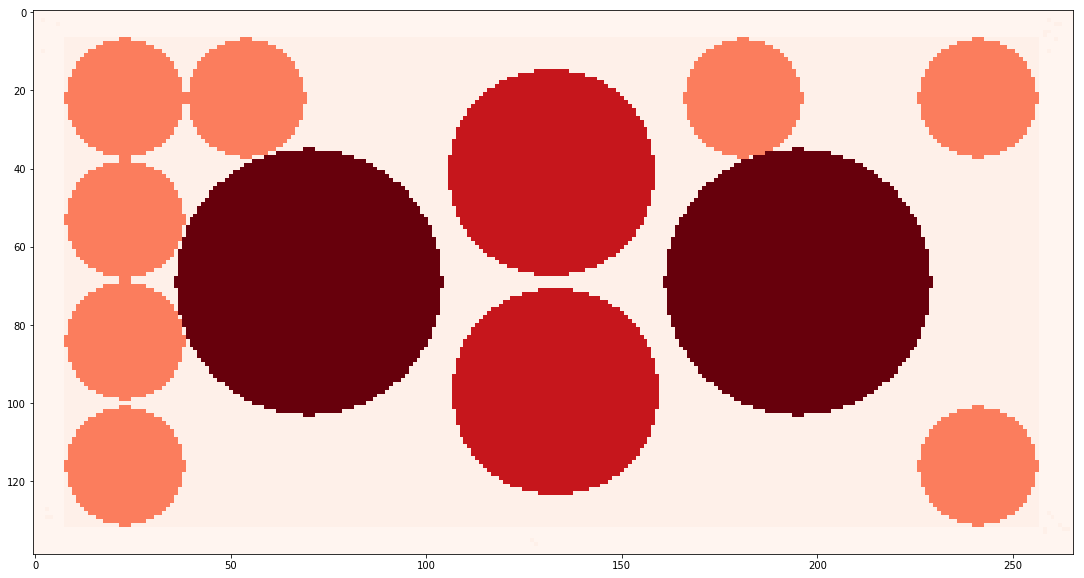

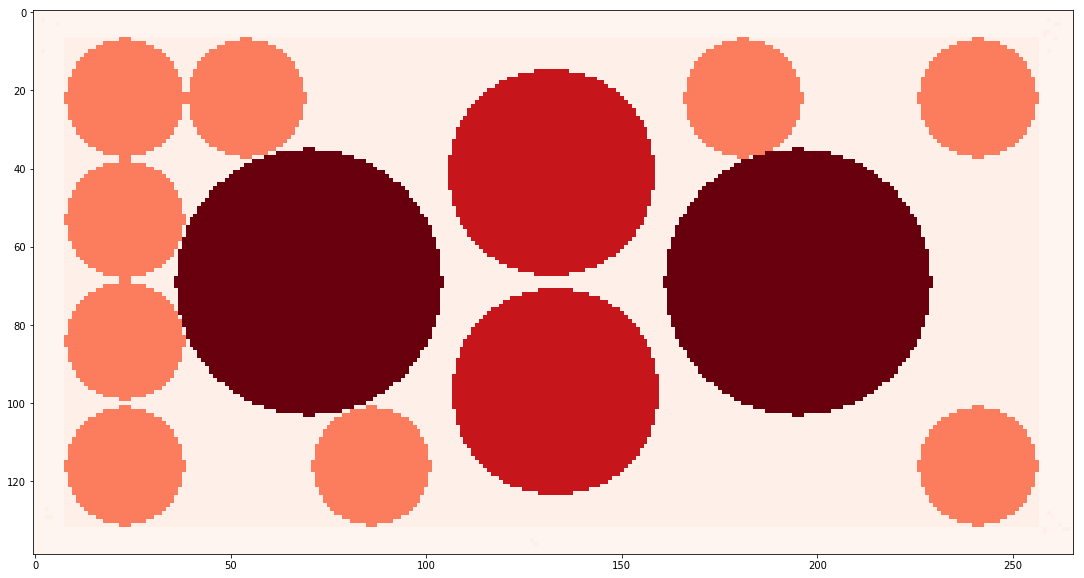

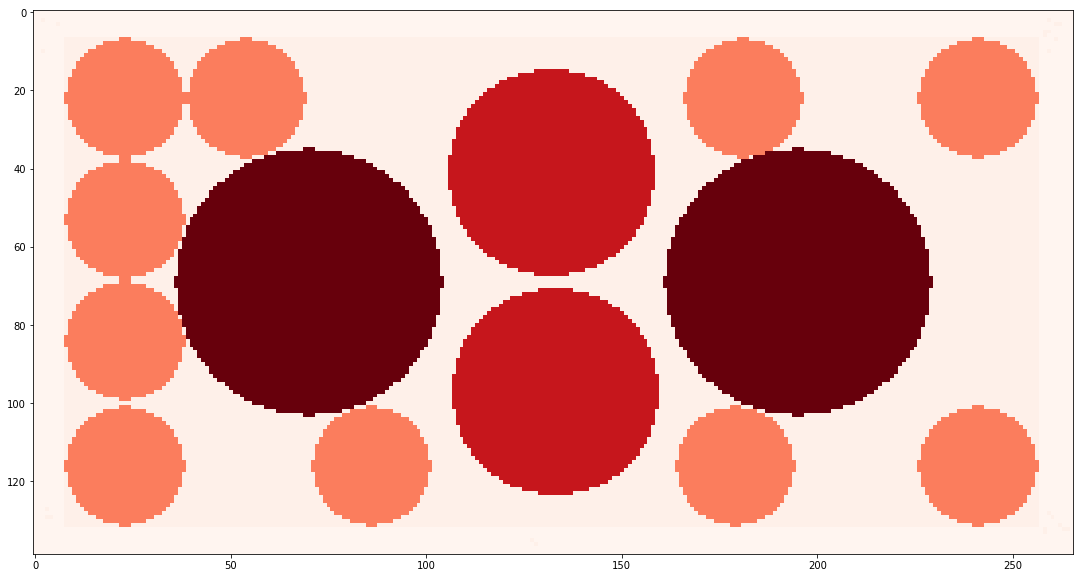

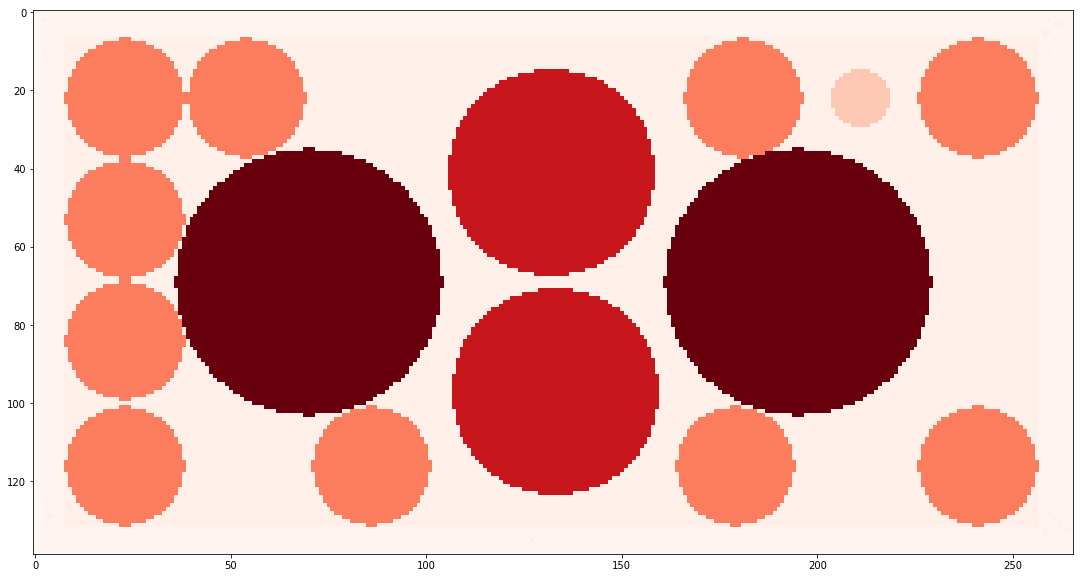

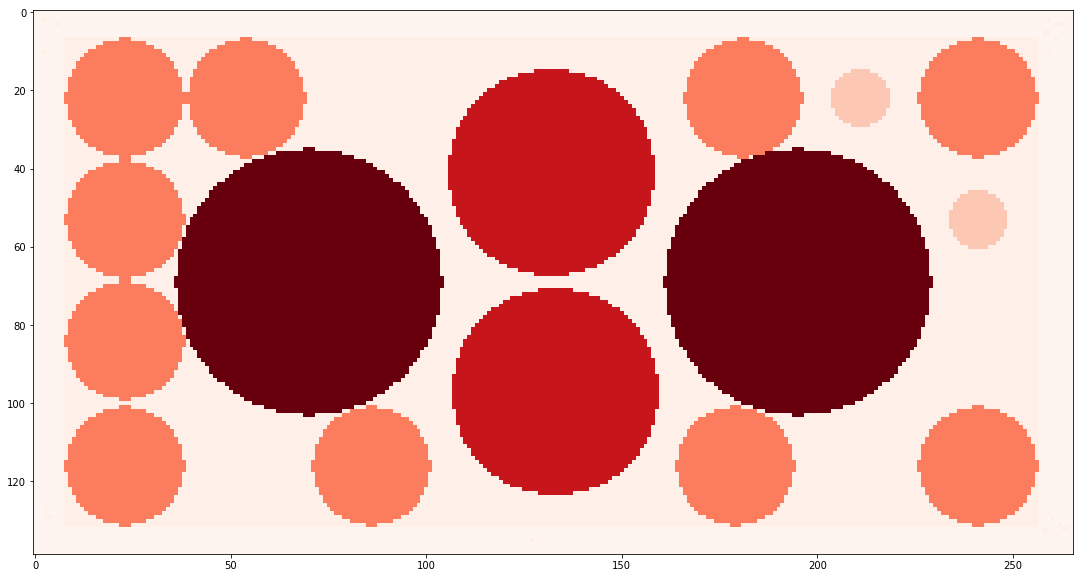

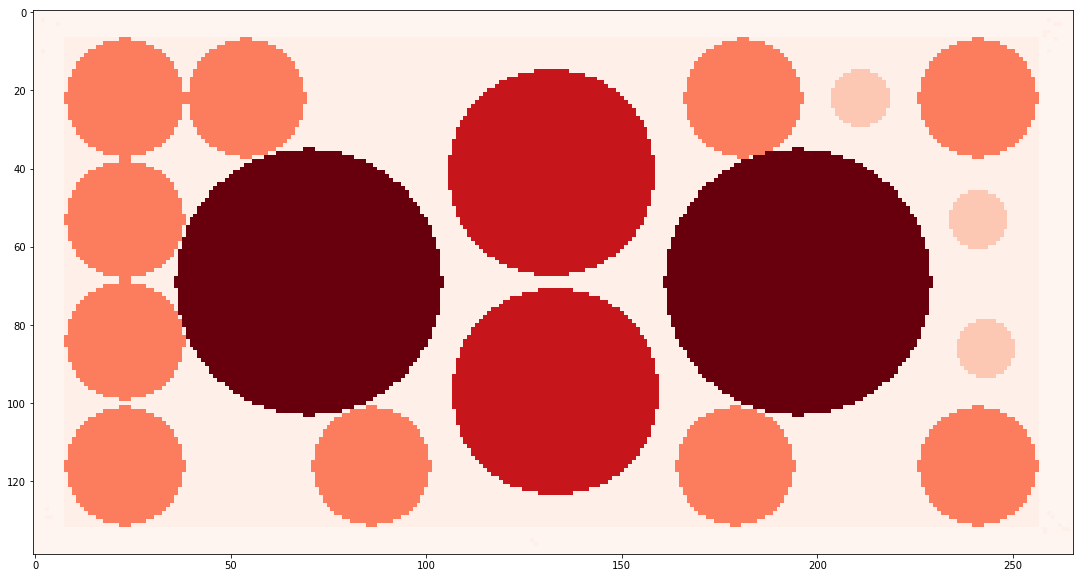

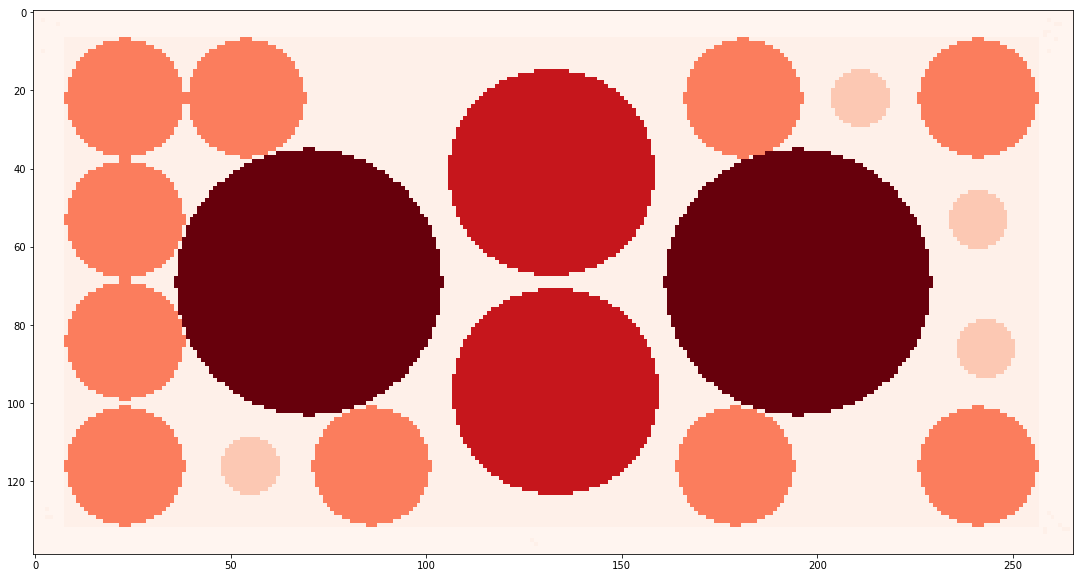

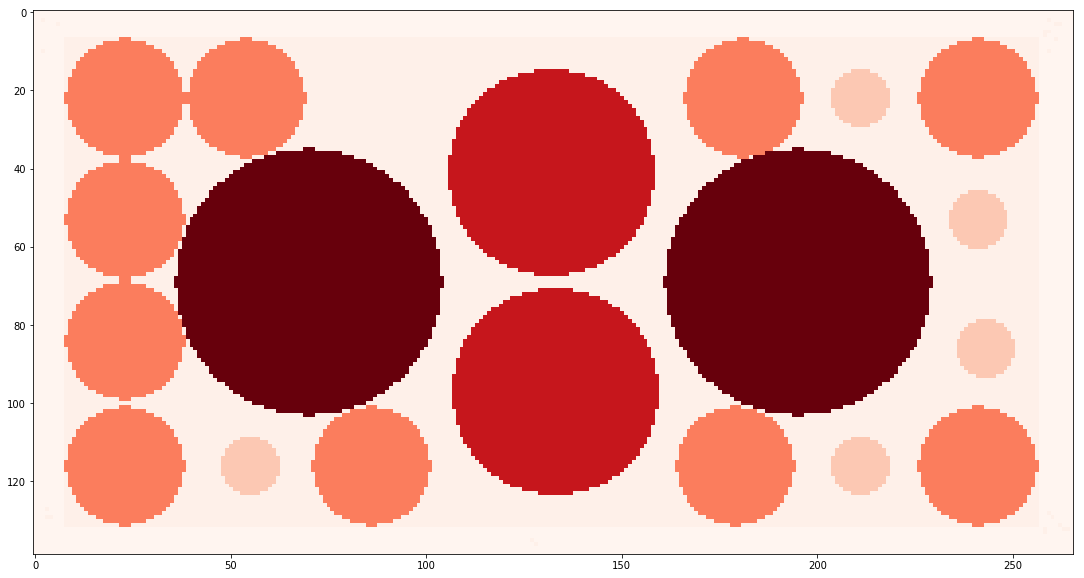

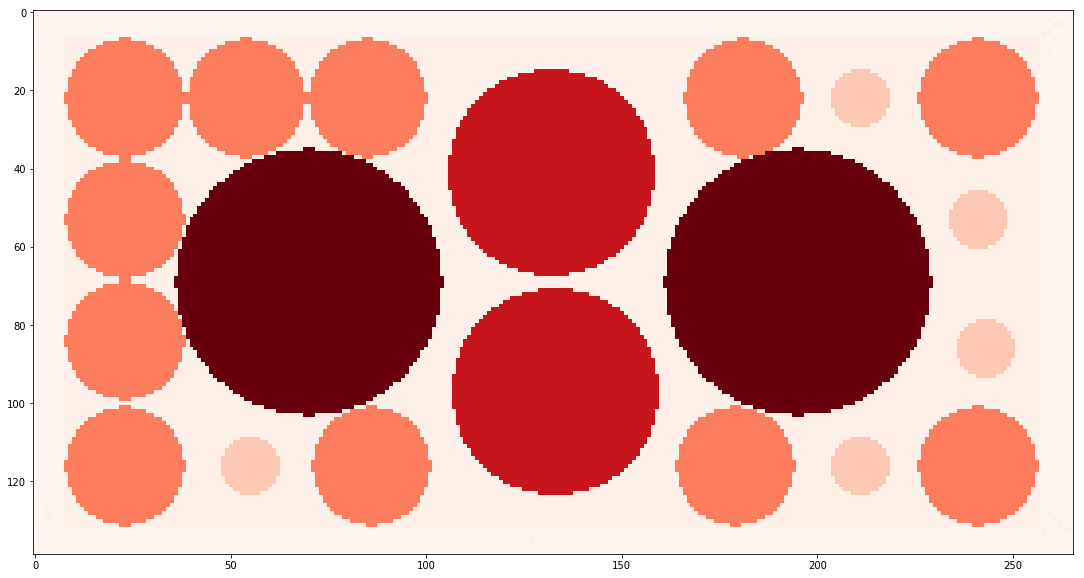

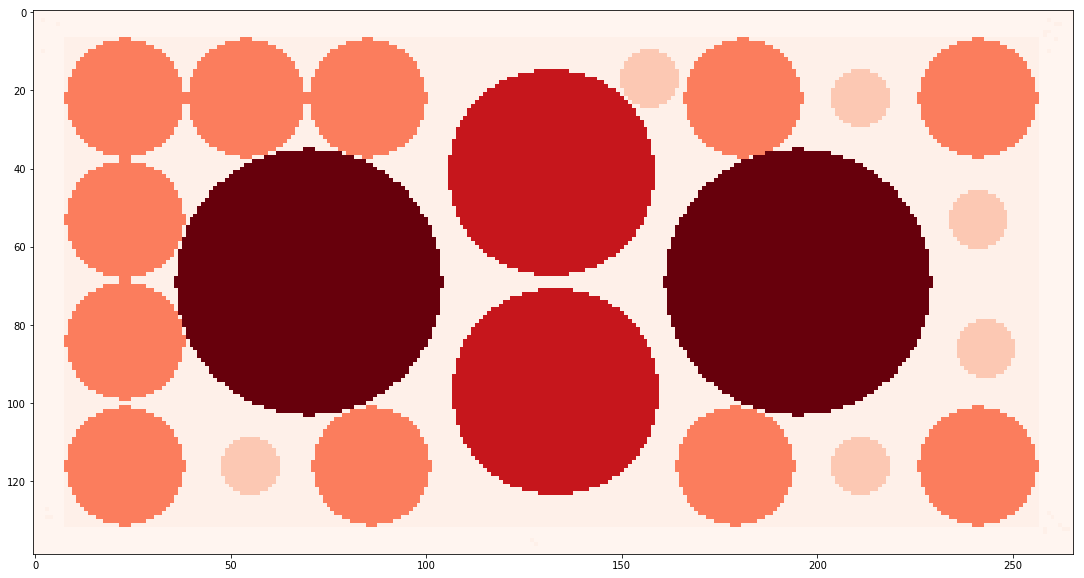

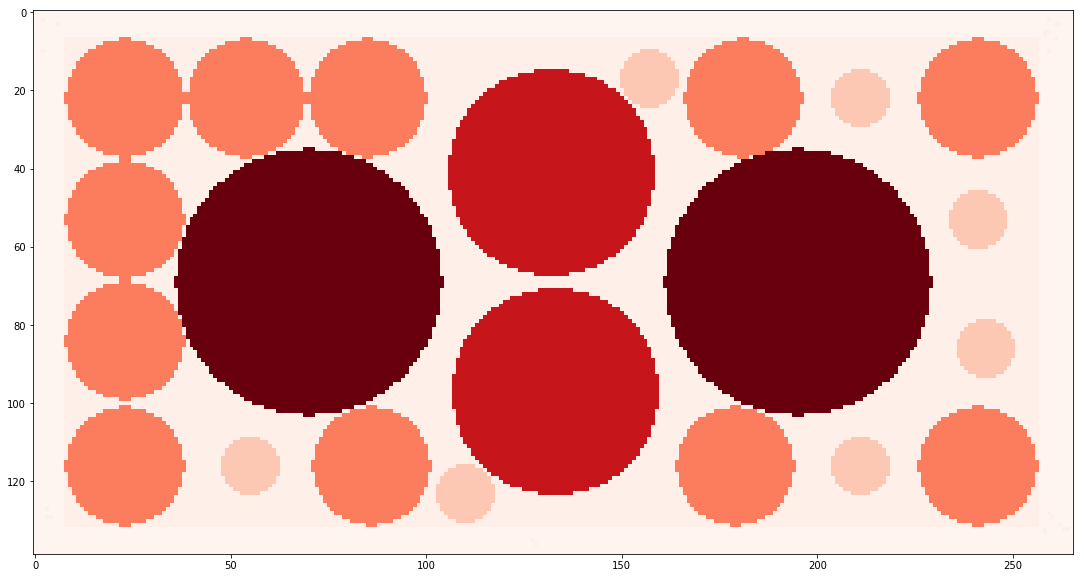

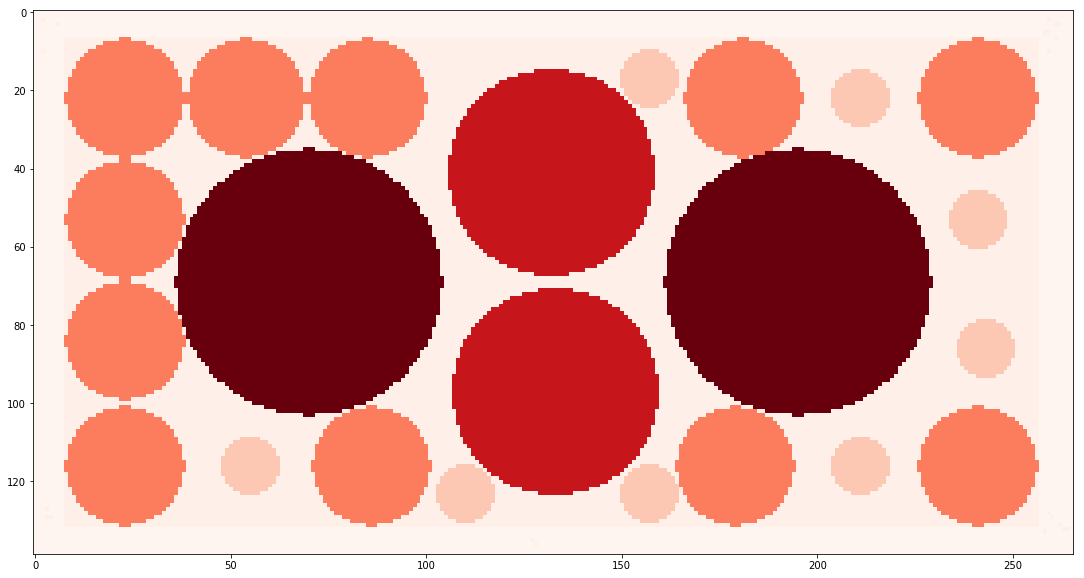

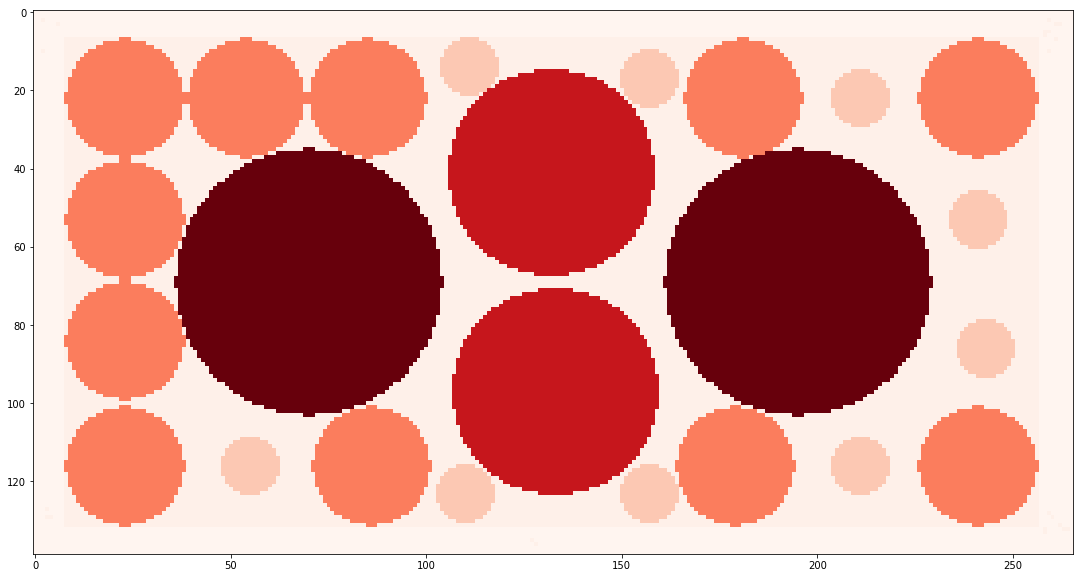

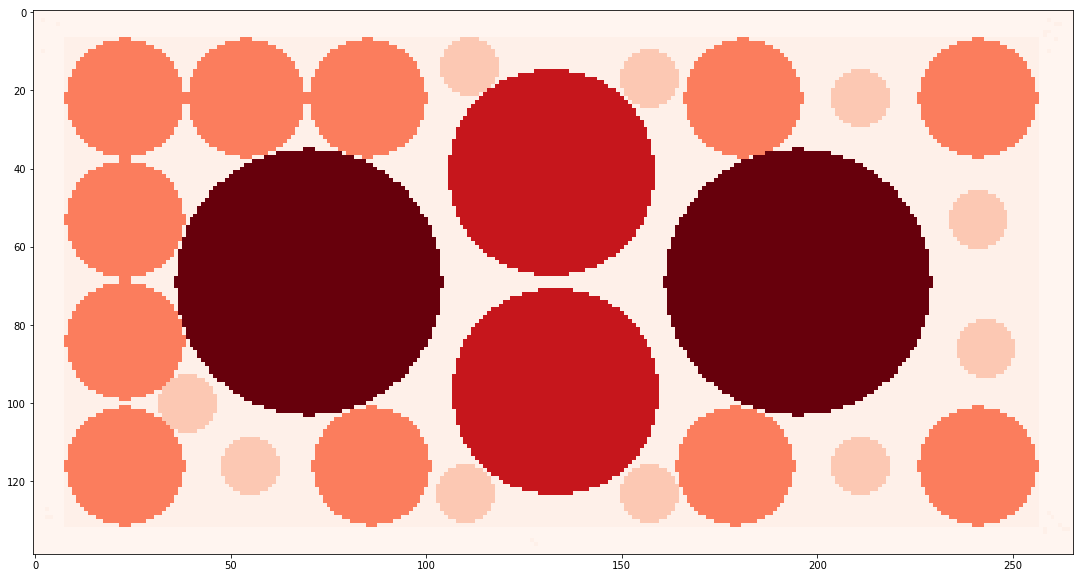

temps= 262.265625


In [32]:
o0,o1,o2,o3,o4=np.copy(objets[0]),np.copy(objets[1]),np.copy(objets[2]),np.copy(objets[3]),np.copy(objets[4])

start=process_time()
test=chirurgie(o0,o4,liste,o1,10)
stop=process_time()
time=stop-start

print("temps=",time)

Ainsi nous avons obtenu une visualisation de la chirurgie aux rayons gamma sur un rectangle. On remarque qu'on ne couvre pas totalement la surface du rectangle, mais les rayons semblent assez répartis pour affecter l'ensemble du rectangle en pratique.

## D. Application à un cas concret <a name="tumeur"></a>

In [33]:
def getalltum(image):
    """ Same as getallrec with the threshold changed. """
    binaire=recadre(binarise(image))
    carte=cartedistance(binaire)
    cartegrad=visualisationgradient(carte)
    gradient=np.gradient(carte)
    skelhyp=squelhyp(carte,binaire)
    squelette=enleveoupas(skelhyp,2.2)
    print("0 : imagebinaire, 1 : cartedistance, 2 : le gradient numpy dx,dy, 3 : possible skeleton, 4 : squelette final")
    return [binaire,carte,gradient,skelhyp,squelette]

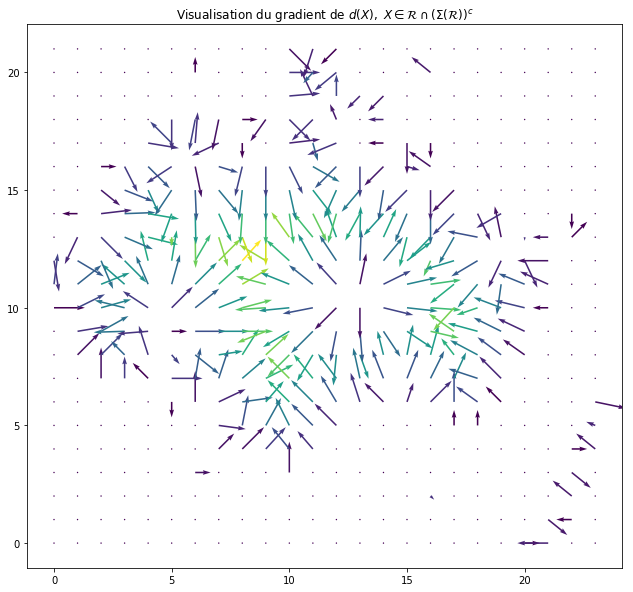

0 : imagebinaire, 1 : cartedistance, 2 : le gradient numpy dx,dy, 3 : possible skeleton, 4 : squelette final


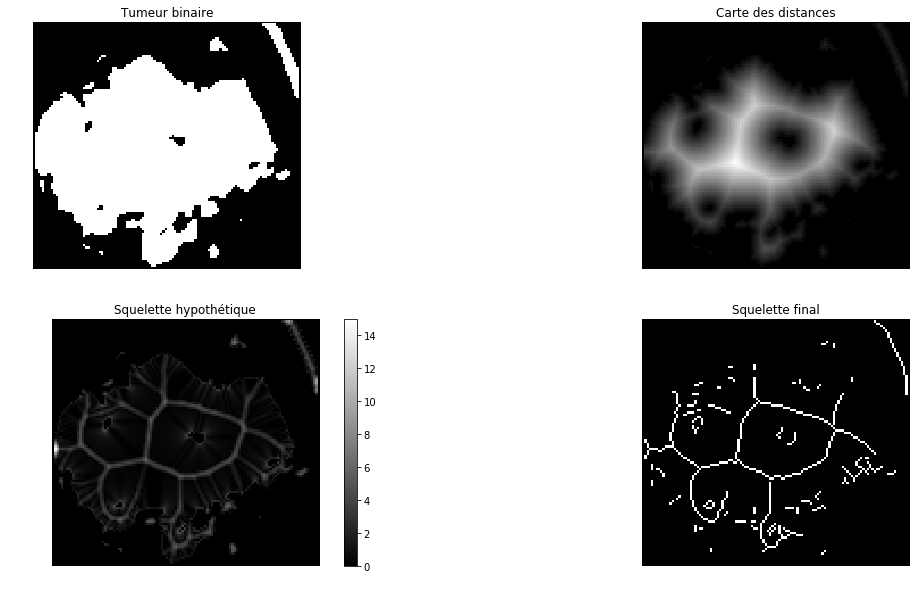

In [52]:
tum=plt.imread('tumeur.jpg')
objetstum=getalltum(tum)

f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(objetstum[0],cmap='gray'); plt.axis('off'); plt.title("Tumeur binaire")
f.add_subplot(2,2, 2)
plt.imshow(objetstum[1],cmap='gray');plt.axis('off'); plt.title("Carte des distances")
f.add_subplot(2,2,3)
plt.imshow(objetstum[3],cmap='gray');plt.axis('off'); plt.title("Squelette hypothétique"); plt.colorbar()
f.add_subplot(2,2,4)
plt.imshow(objetstum[4],cmap='gray');plt.axis('off'); plt.title("Squelette final");
plt.show(block=True)

Rentrez les 4 rayons en millimètres un-par-un.
1
2
2.5
3.5


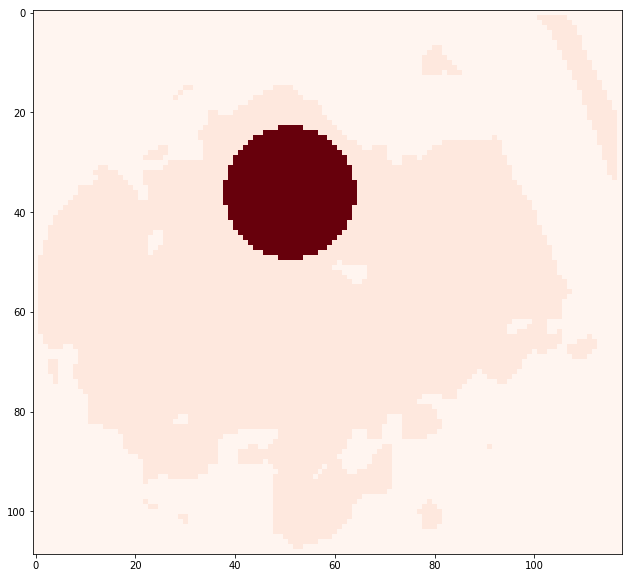

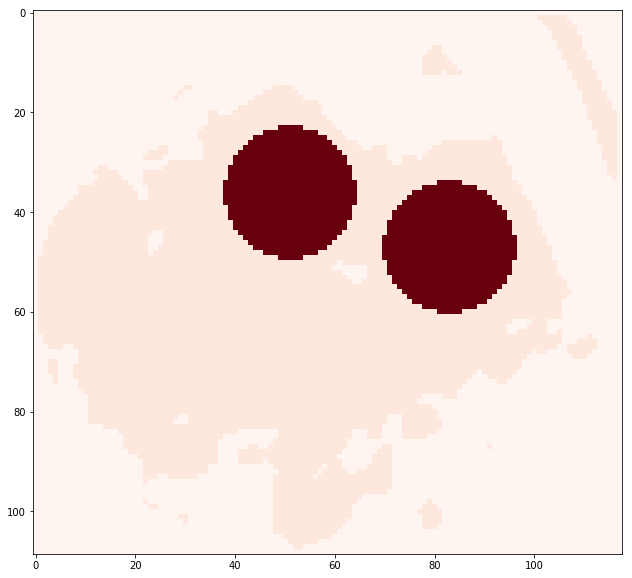

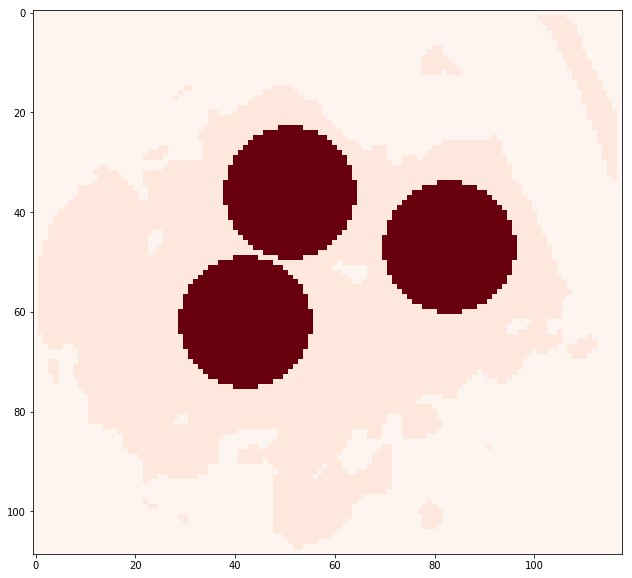

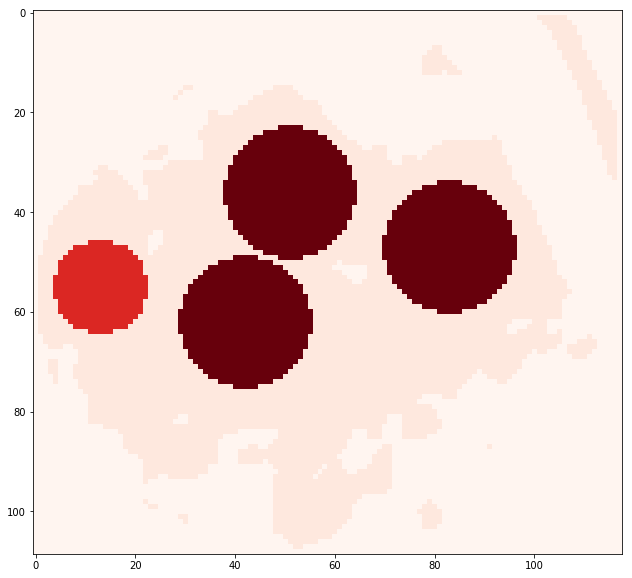

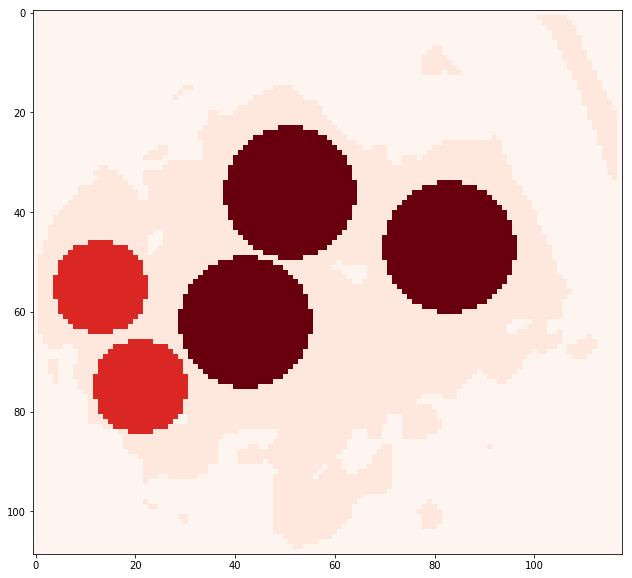

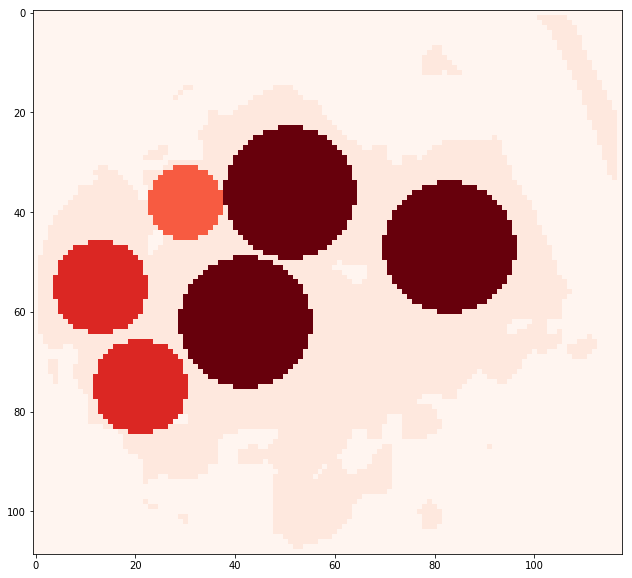

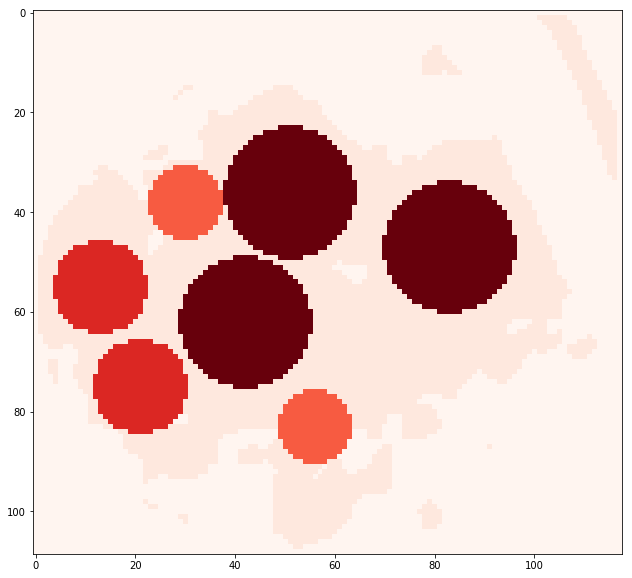

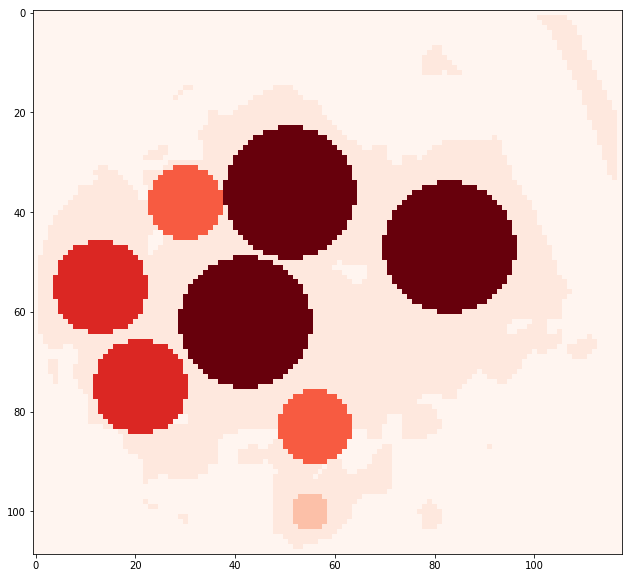

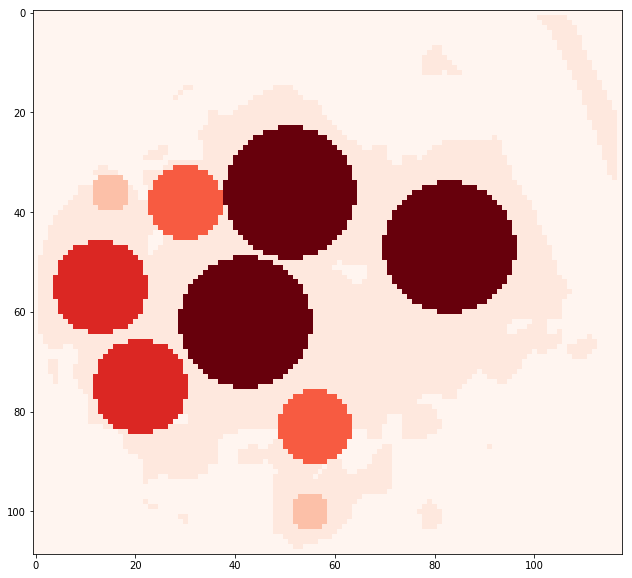

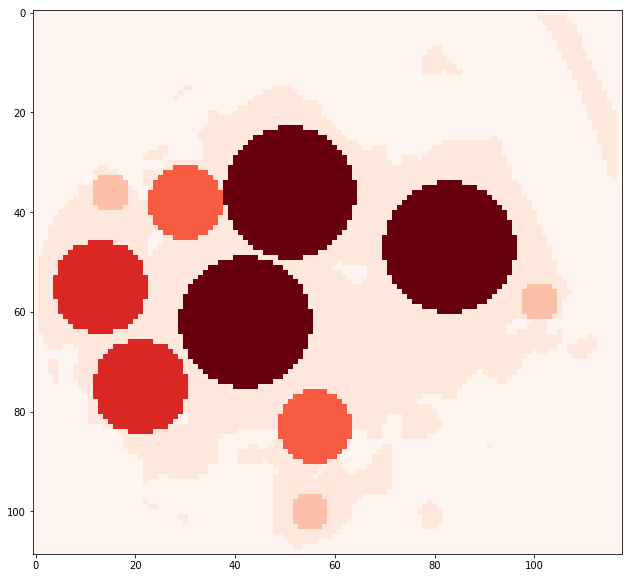

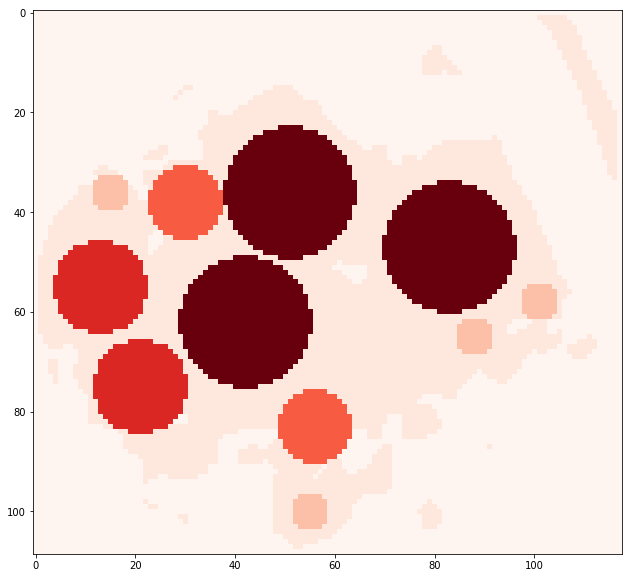

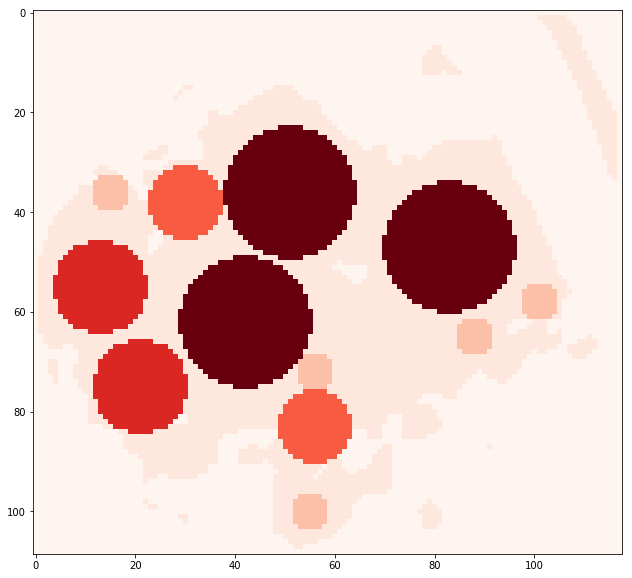

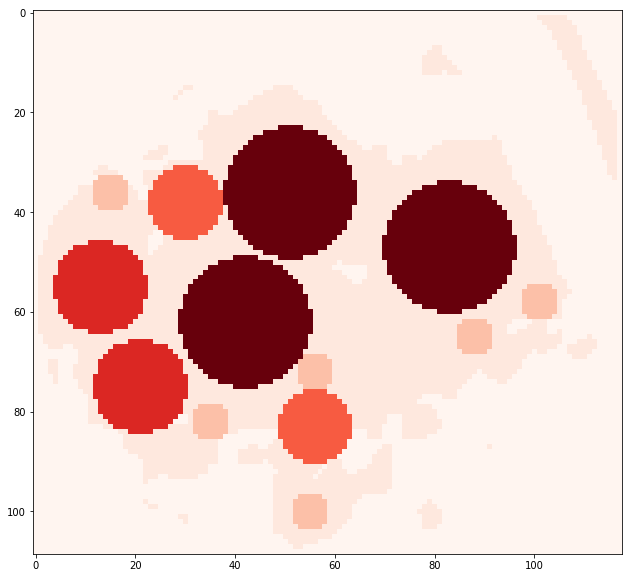

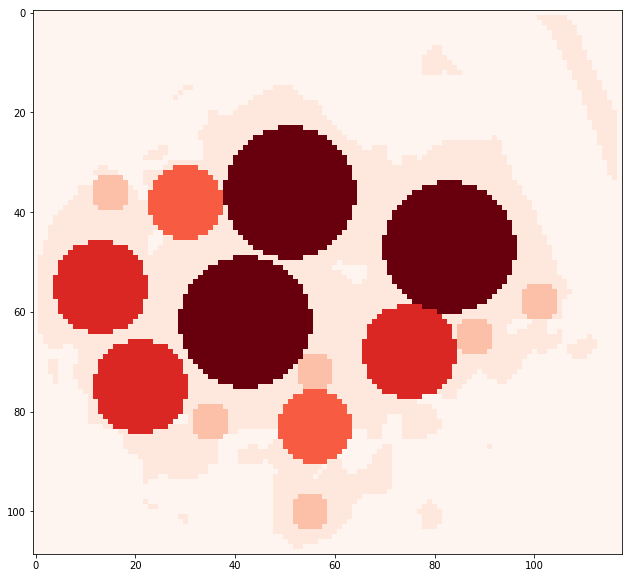

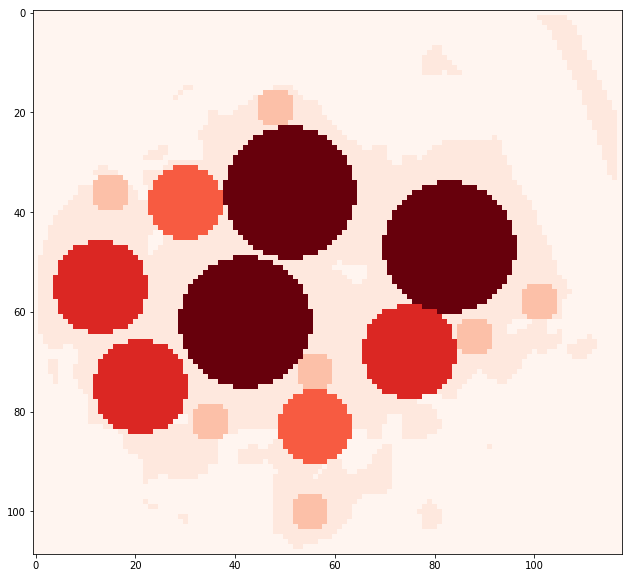

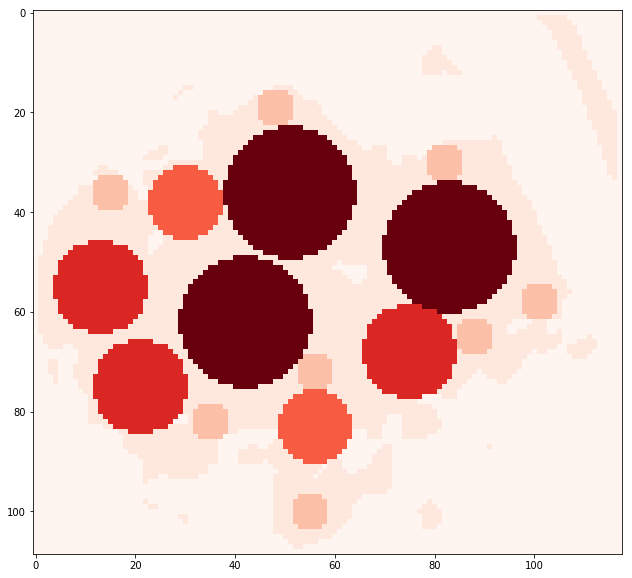

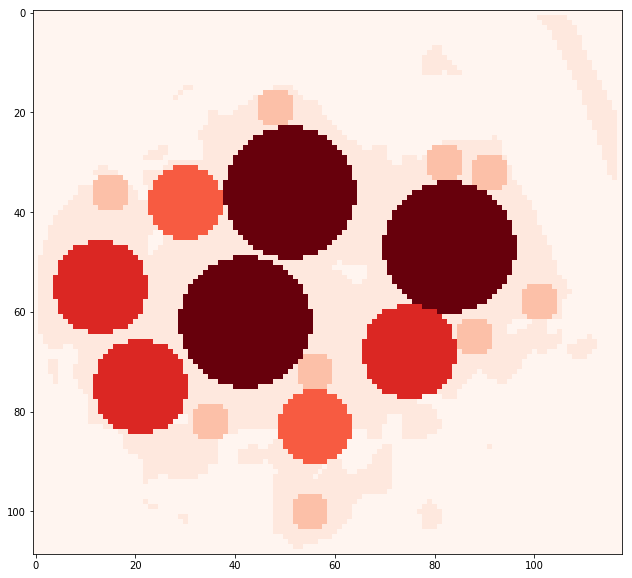

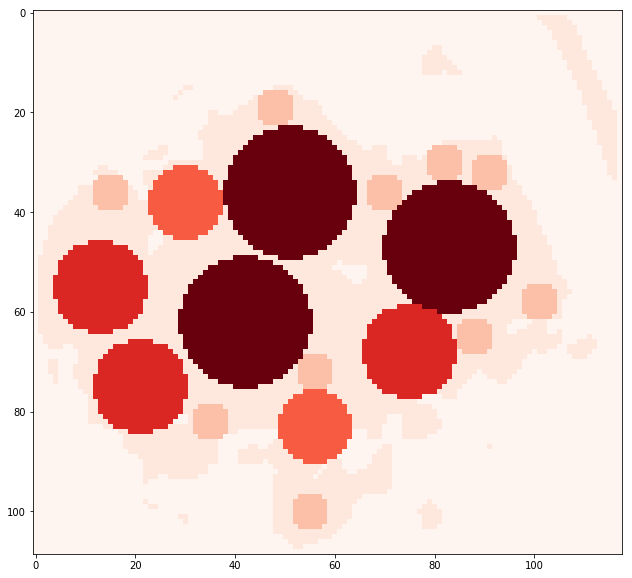

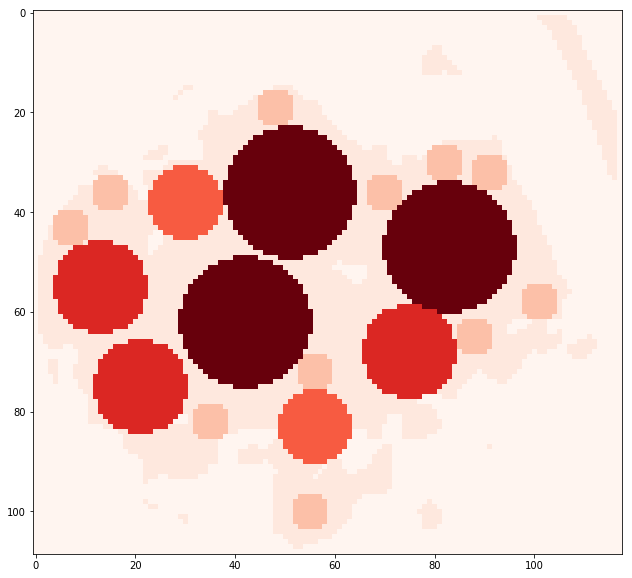

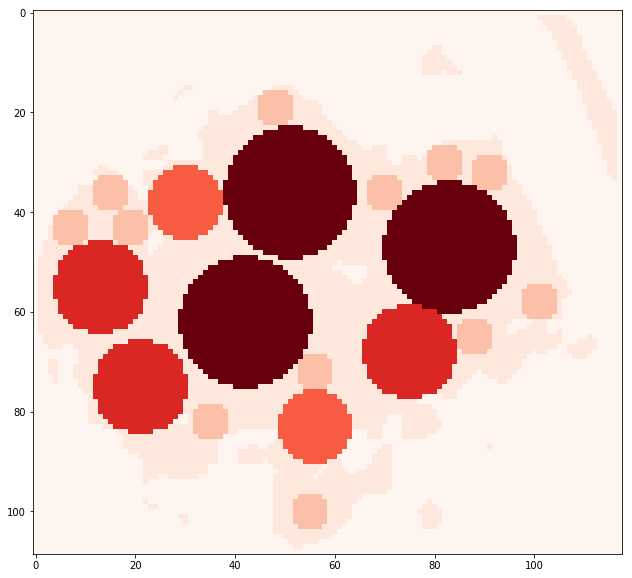

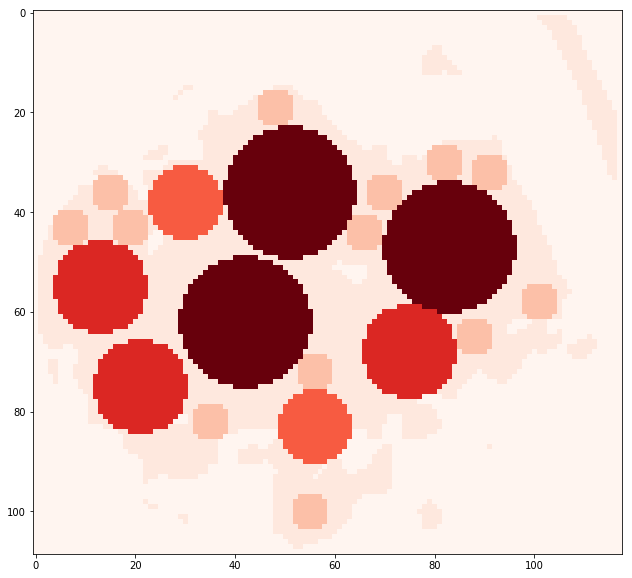

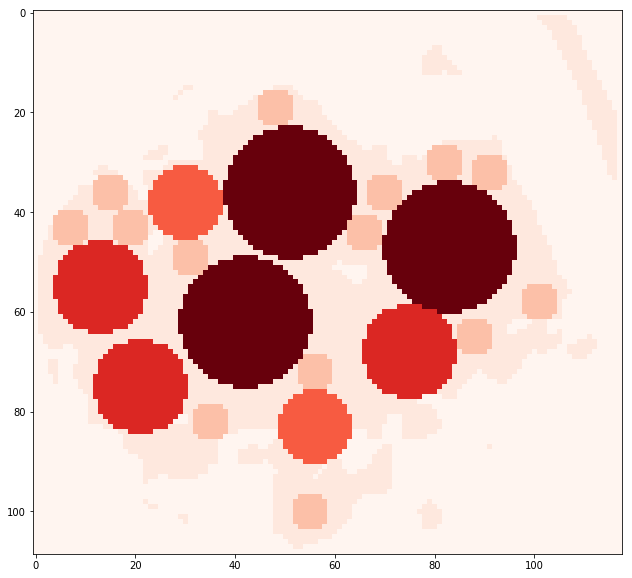

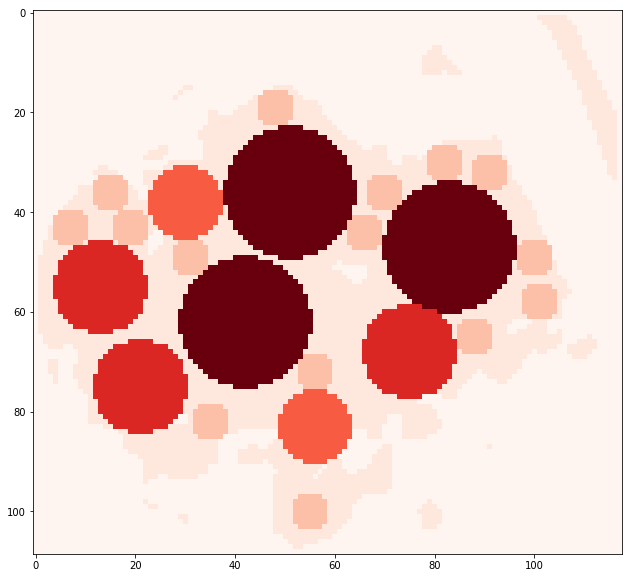

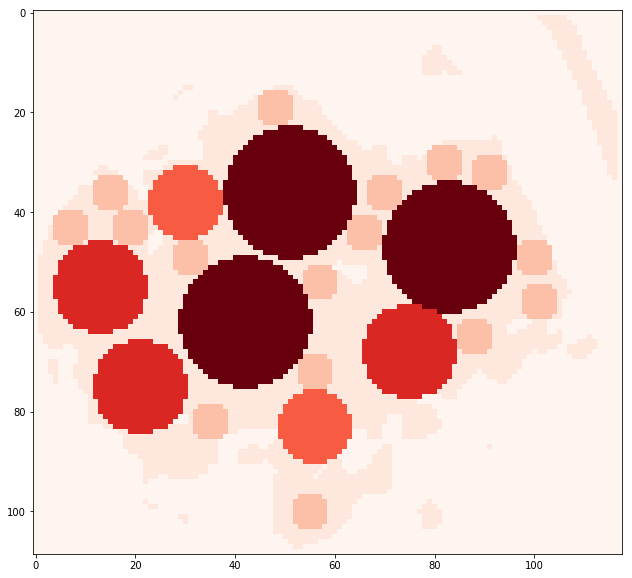

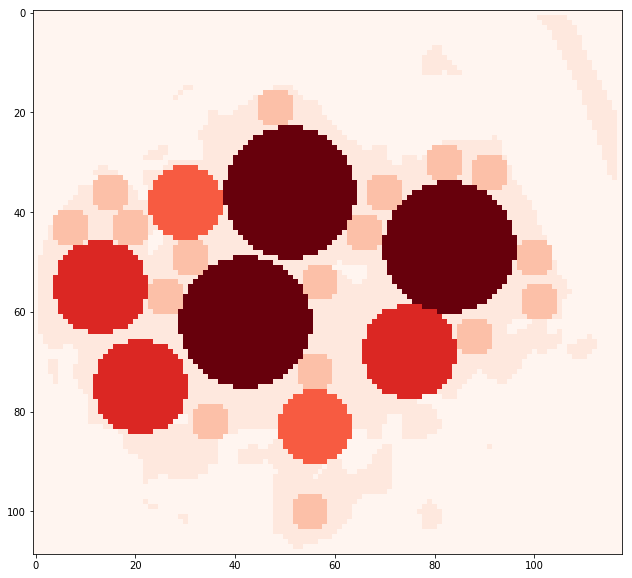

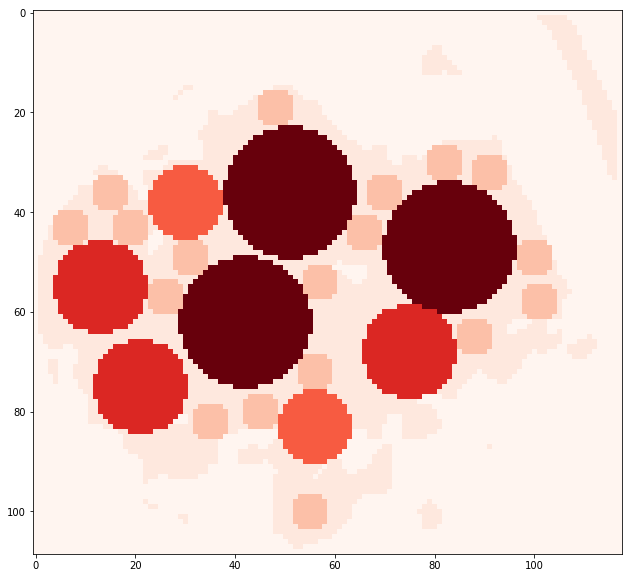

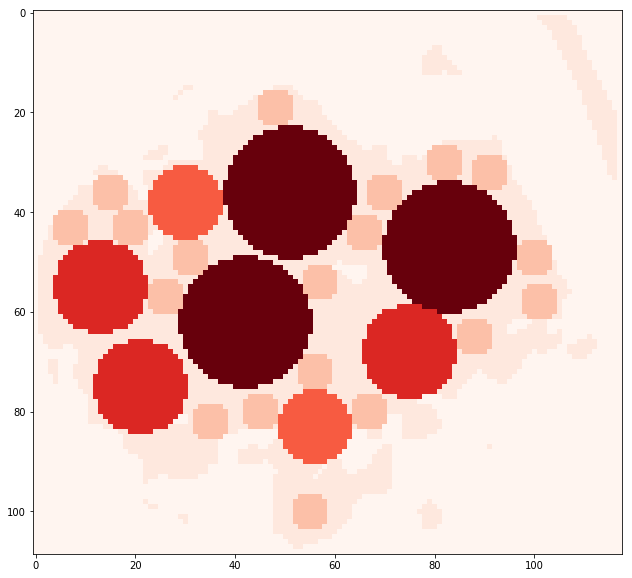

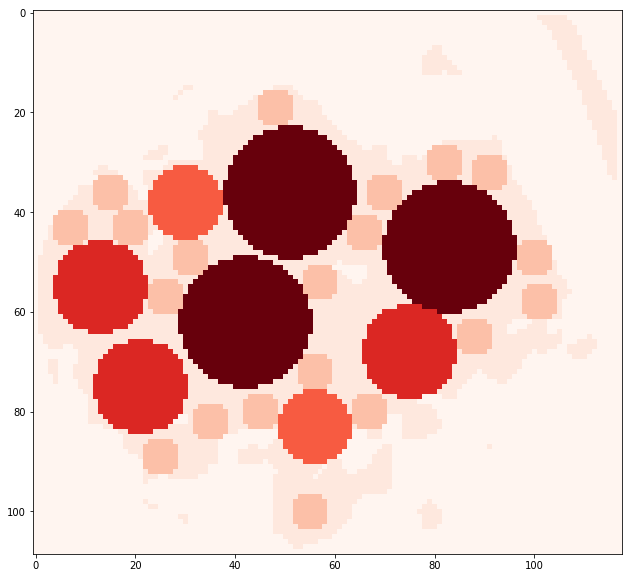

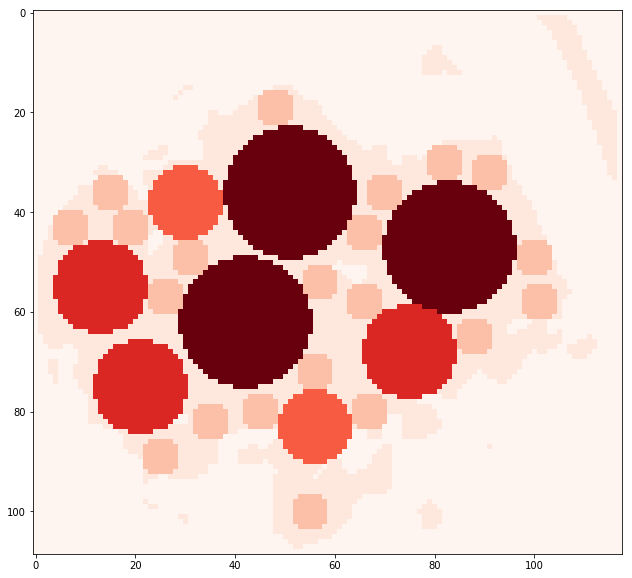

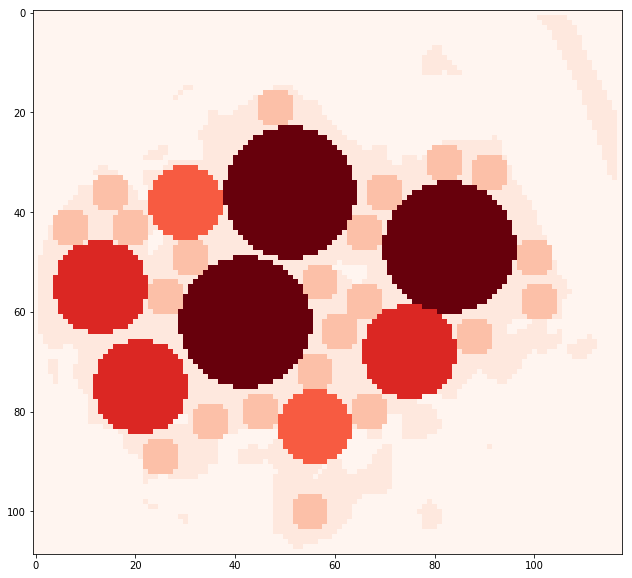

In [53]:
liste=listerayons()   #1,2,2.5 et 3.8 mm permettent une bonne visualisation de l'algorithme en un temps très faible
testtum=chirurgie(objetstum[0],objetstum[4],liste,objetstum[1],15)

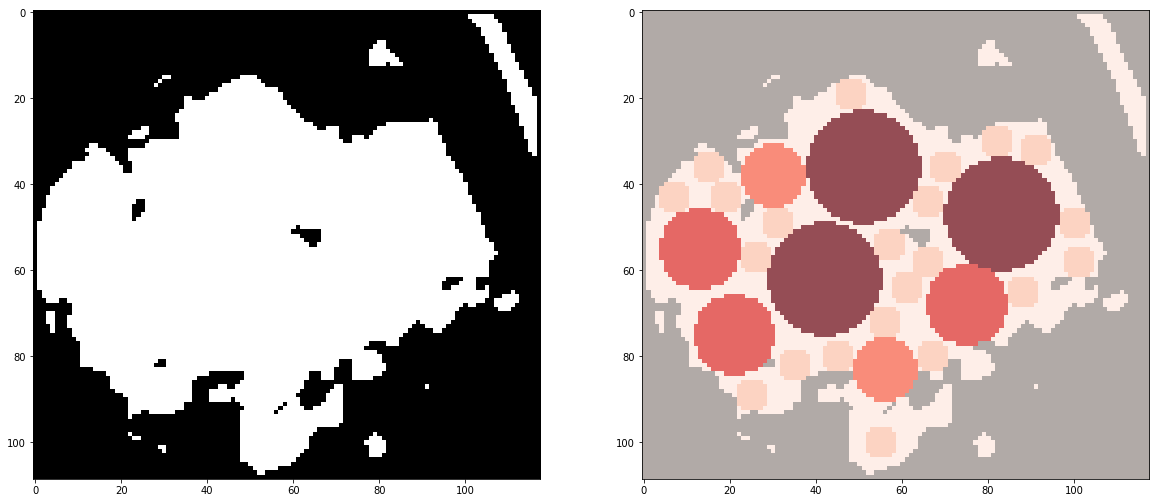

In [54]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(objetstum[0], 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(objetstum[0], 'gray', interpolation='none')
plt.imshow(testtum, 'Reds', interpolation='none', alpha=0.7) #alpha pour la transparence
plt.show()

La région tumorée est en majorité recouverte de rayons gamma. On peut supposer que leur action s'étendra sur l'ensemble de la tumeur. De plus, les rayons des disques étaient choisis assez grands pour ne pas pouvoir irradier l'ossature du crâne (visible dans le cadrant supérieur droit).

# <center>IV. Conclusion et améliorations possibles <a name='conclu'></a></center>

Nous avons donc implémenté un algorithme permettant d'obtenir le squelette d'une région. A partir du squelette nous avons ensuite appliqué un algorithme imitant la chirurgie aux rayons gamma. On remarque que le choix du seuil et celui des rayons est déterminant pour avoir une chirurgie de qualité.

Une façon d'améliorer ce programme serait de faire en sorte que le seuil ne soit pas à déterminer manuellement et s'adapte tout au long de la chirurgie pour maximiser le rendu final. De plus, pour un rendu plus rapide, une des fonctions dont la performance serait à améliorer est `cartedistance` car celle-ci a une place centrale dans le projet et l'améliorer nous permettrait d'avoir un gain de temps sur la squelettisation et la chirurgie.

# Bonus : Visualisation du squelette dans l'espace <a name='bonus'></a>

Nous avons pu voir le squelette d'un objet dans le plan. Cependant, une tumeur n'est pas un objet planaire. Nous vous proposons donc maintenant une visualisation du squelette d'un pavé dans l'espace. Celle-ci se base sur le même principe que dans le plan.

In [72]:
%matplotlib notebook   
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#charger la cellule un grand nombre de fois (10 à 20) pour que le changement soit effectué et faire les graphiques suivant
# un par un permet d'éviter toute erreur de matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 10]  #agrandir les images pour mieux voir le comportement des pixels

In [73]:
c=np.ones((30,30,60))    #le pavé de taille 30*30*60

c[:,:,0]=c[:,:,-1]=0        #les trois lignes permettent d'avoir une frontière
for i in range(60):
    c[0,:,i]=c[-1,:,i]=c[:,-1,i]=c[:,0,i]=0

    
tabt=np.where(c==1)
tabt=np.vstack((np.vstack((tabt[0],tabt[1])),tabt[2]))  #points dans la région
tabf=np.where(c==0)
tabf=np.vstack((np.vstack((tabf[0],tabf[1])),tabf[2]))   #points dans la frontière

imagecarte=np.copy(c).astype(float)
for k in range(np.shape(tabt)[1]):           #création de la carte des distances
    imagecarte[tuple(tabt[:,k])]=min(np.linalg.norm(np.array([[tabt[0,k]],[tabt[1,k]],[tabt[2,k]]])-tabf,axis=0))

In [74]:
def normal3d(pointorigine,pointatteint):
    """ Computes the coordinates of a vector in 3D. """
    coord=np.array([pointatteint[0]-pointorigine[0],pointatteint[1]-pointorigine[1],pointatteint[2]-pointorigine[2]])
    return coord

def pointsautour3d(pointorigine):
    """ Array of the coordinates of the 26 pixels around an origin. """
    return pointorigine+np.array([[-1,-1,-1, -1,-1,-1, -1,-1, 0, 0, 0, 0,0,0,  0, 0, 1,  1,  1,1,1,1,  1, 1, -1,1],
                                  [-1,0, 1,   1,1, 0,  -1,-1, -1,0, 1, 1,1,0, -1,-1, -1, 0,  1,1,1,0, -1, -1, 0,0],
                                  [-1,-1,-1,  0,1, 1,   1,0,  -1,-1,-1,0,1,1,  1, 0, -1,-1, -1,0,1,1,  1, 0,  0,0]])

def gradenXi3d(cartedistance,pointorigine):    
    """Computes the gradient for the points in the 26-neighborhood. """
    dx,dy,dz=np.gradient(cartedistance)
    listepoints=pointsautour3d(pointorigine)
    return np.array([dx[tuple(listepoints.tolist())],dy[tuple(listepoints.tolist())],dz[tuple(listepoints.tolist())]])

def ibarre3d(cartedistance,pointorigine):
    """ Computes I(X) from a given point X and a distance transform map. """
    N=normal3d(pointorigine,pointsautour3d(pointorigine))
    G=gradenXi3d(cartedistance,pointorigine)
    return 2*np.pi/26*sum([np.dot(N[:,i],G[:,i]) for i in range(26)])

In [75]:
image=np.zeros_like(c).astype(float)    #calcul du "squelette hypothétique" (voire la remarque sous la visualisation)
for i in range(0,np.shape(tabt)[1]):
    image[tuple(tabt[:,i].flatten())]=abs(ibarre3d(imagecarte,np.reshape(tabt[:,i],(-1,1))))

<IPython.core.display.Javascript object>


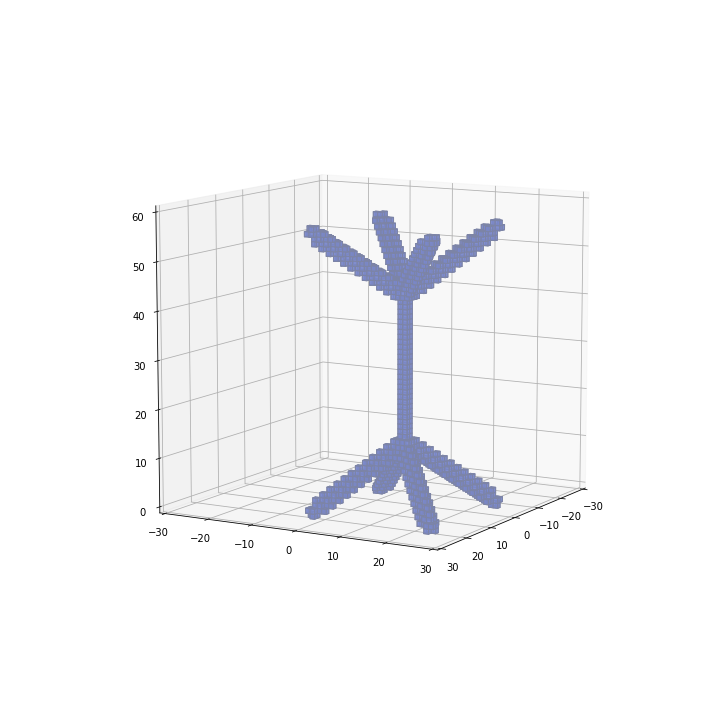

In [76]:
fig=plt.figure('Visualisation la partie linéaire du squelette sans affinage')
ax=fig.gca(projection='3d')
ax.set_zlim(0,60)
ax.set_ylim(-30,30)
ax.set_xlim(-30,30)
ax.view_init(10,30)
ax.voxels(image>3,edgecolors='#7D84A6',facecolors='#7A88CCC0')
plt.show()  #les visualisations peuvent être manipulées (notamment l'angle de visualisation)

In [77]:
print('Il y avait',np.shape(np.where(c==1))[1],'voxels dans le pavé.')
print('La visualisation est composée de',np.shape(np.where(image>3))[1],'voxels.')  
print('Nous ne gardons donc que', np.shape(np.where(image>3))[1]/np.shape(np.where(c==1))[1]*100, '% de voxels.')

Il y avait 45472 voxels dans le pavé.
La visualisation est composée de 1136 voxels.
Nous ne gardons donc que 2.4982406755805773 % de voxels.


On peut bien sûr envoyer des boules de rayons gamma pour effectuer la chirurgie. L'idée étant la même que dans le plan, envoyons seulement une boule en un point. Commençons par binariser l'image et ensuite nous créons la boule de rayon $r=10$ au point $(15,10,30)$.

In [78]:
image =  image>3  #la valeur de seuil 3 est trouvée par expérimentation

<IPython.core.display.Javascript object>


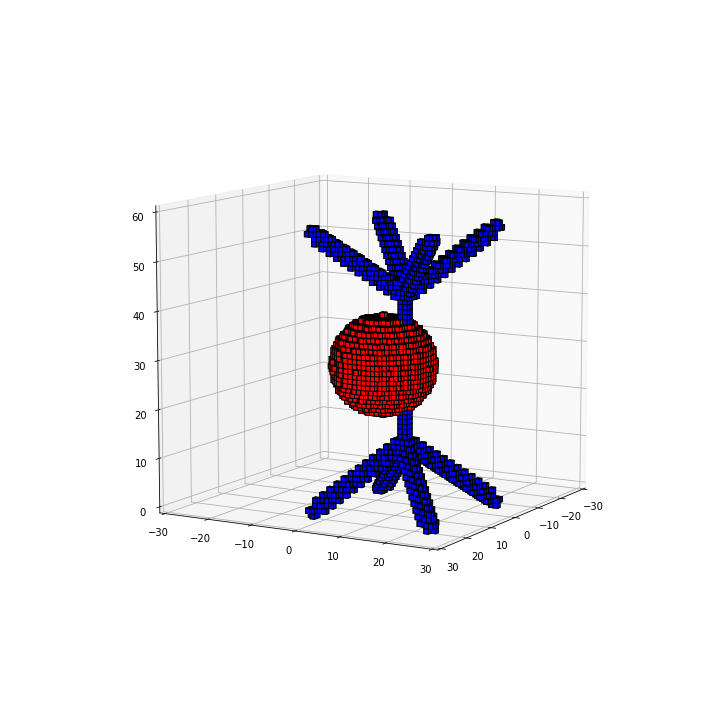

In [79]:
boule=np.zeros_like(image)
centre=np.array([[15.],[10.],[30.]]).flatten()
rayon=10.
for x in range(int(centre[0]-rayon),int(centre[0]+rayon+1)):
    for y in range(int(centre[1]-rayon),int(centre[1]+rayon+1)):
        for z in range(int(centre[2]-rayon),int(centre[2]+rayon+1)):
            if ((x-centre[0])**2+(y-centre[1])**2+(z-centre[2])**2)<=rayon**2 : boule[x,y,z]=1

imagefinale= boule | image

couleurs = np.empty(imagefinale.shape, dtype=object)
couleurs[boule] = 'red'
couleurs[image] = 'blue'

fig=plt.figure('Visualisation de la boule de rayons gamma')
ax=fig.gca(projection='3d')
ax.set_zlim(0,60)
ax.set_ylim(-30,30)
ax.set_xlim(-30,30)
ax.view_init(10,30)
ax.voxels(imagefinale,edgecolors='black',facecolors=couleurs)
plt.show()


Si l'on reprend la définition du squelette, il nous faut simplement que la sphère maximale intersecte la frontière en au moins $2$ points. Cette visualisation en $3$ dimensions nous donne les points dont la sphère intersecte la frontière en au moins $3$ points. Cela correspond à la partie linéaire du squelette et non le squelette en son ensemble. (On notera que la visualisation n'a pas été affinée pour avoir le squelette final.)

In [80]:
c=np.ones((10,30,20))             #on définit un nouveau pavé avec sa frontière
if np.shape(c)[2]%2==1 :                #cette condition modifie d'un voxel la dimension du pavé pour ne pas avoir un
    c[:,:,0]=c[:,:,-1]=0                    # 'vide' au centre du squelette (on aurait pu garder le même squelette et choisir)
    for i in range(np.shape(c)[2]):                #un seuil de précision pour la distance.
        c[0,:,i]=c[-1,:,i]=c[:,-1,i]=c[:,0,i]=0  
else:
    c=np.ones((np.shape(c)[0]+1,np.shape(c)[1]+1,np.shape(c)[2]+1))
    c[:,:,0]=c[:,:,-1]=0
    for i in range(np.shape(c)[2]):
        c[0,:,i]=c[-1,:,i]=c[:,-1,i]=c[:,0,i]=0
    
tabt=np.where(c==1.)
tabt=np.vstack((np.vstack((tabt[0],tabt[1])),tabt[2]))   #points de la région
tabf=np.where(c==0.)
tabf=np.vstack((np.vstack((tabf[0],tabf[1])),tabf[2]))  #points de la frontière


imagecarte=np.zeros_like(c)
compte=np.zeros_like(c)
for k in range(np.shape(tabt)[1]):  #on calcule la carte des distances, et si le minimum des distances est atteint au moins
                                    #2 fois alors le point appartient au squelette.
    liste=np.linalg.norm(np.array([[tabt[0,k]],[tabt[1,k]],[tabt[2,k]]])-tabf,axis=0)
    imagecarte[tuple(tabt[:,k])]=min(liste)
    if np.shape(np.where(liste==min(liste)))[1]>=2 : compte[tuple(tabt[:,k])]=1

<IPython.core.display.Javascript object>


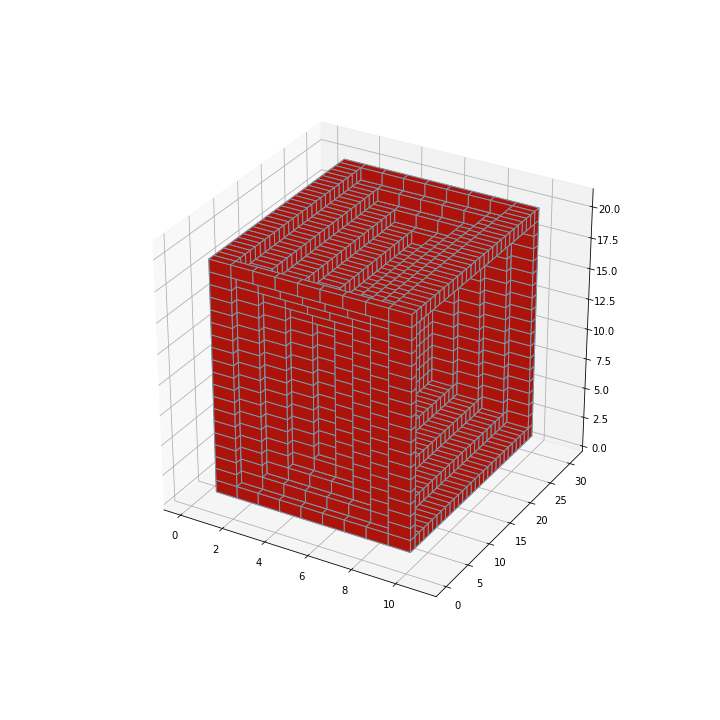

In [81]:
fig=plt.figure('Squelette du pavé')
ax=fig.gca(projection='3d')
ax.voxels(compte,edgecolors='#7D96A6',facecolors='#AB130B')
plt.show() 

In [82]:
print("Le pavé était composé de",np.shape(np.where(c==1))[1],"voxels.")
print("Le squelette est composé de",np.shape(np.where(compte==1))[1],"voxels.")
print('Nous ne gardons donc que', np.shape(np.where(compte==1))[1]/np.shape(np.where(c==1))[1]*100, '% de pixels.')

Le pavé était composé de 4959 voxels.
Le squelette est composé de 935 voxels.
Nous ne gardons donc que 18.854607783827383 % de pixels.


Ainsi, le squelette d'un pavé est composé de plans. La partie linéaire n'était que l'intersection de ceux-ci.

On remarque que l'importance dans le traitement d'une région grâce au squelette est la même dans le plan ou dans l'espace. Le squelette (et sa linéarisation) nous permettent de ne traiter qu'une très petite partie de l'information et ainsi de gagner du temps dans d'éventuelles opérations par la suite. 